In [30]:
import warnings, pickle, os, itertools

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})
plt.rc("axes", titlesize=14, labelsize=14)
plt.rc('figure', titlesize=16)

import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from utils.evaluation import *
from models import *
from systematic_comparison import get_xy
%aimport utils.evaluation, models, systematic_comparison

In [32]:
class Notebook:
    SYS_RESULTS_DIR = 'models/sys_select_long/'
    TIME_RESULTS_DIR = 'models/time_short/'
    TIME_PERSISTED_RESULTS_DIR = 'models/time_far_short'
    IMAGE_DIR = 'results/images/systematic'

def load_results(directory, exclude=['OneClassSVM', 'IsolationForest']):
    result_files = [f'{directory}/{_}' for _ in os.listdir(directory) if _.endswith('.h5')]
    y_preds = pd.concat([pd.read_hdf(_, 'y_preds') for _ in result_files], axis=1)
    metrics = pd.concat([pd.read_hdf(_, 'metrics') for _ in result_files], axis=0).reset_index(drop=True)
    # hyperparameters = {name: optuna.load_study(study_name = name, storage=Notebook.STORAGE).best_params for name in metrics.name.values}

    if len(exclude):
        metrics = metrics[~metrics.estimator.isin(exclude)].copy()
        y_preds = y_preds[metrics.name.values].copy()

    return metrics, y_preds

def load_model(name, directory):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        with open(f'{directory}/models/{name}.bin', 'rb') as file:
            return pickle.load(file)

In [33]:
from sklearn.model_selection import train_test_split
from dataset import SCIData, SCICols
%aimport dataset

sci = SCIData.load('data/sci.h5')

scii = (
    SCIData(
        SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime")
    )
    .mandate(SCICols.news_data_raw)
    .augment_shmi(onehot=True)
    .derive_ae_diagnosis_stems(onehot=False)
    .derive_critical_event(within=1, return_subcols=True)
)

sci_train, sci_test = train_test_split(
    scii,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

In [34]:
select_num_cols = dict(
    Age='Age (years)', 
    TotalLOS='LOS (days)',
  #  ReadmissionTimespan='Readmission',
    NEWS_score='NEWS',
    O2_saturation='SpO2 (%)',
    Respiration_rate='RR (breaths/min)',
    HeartRate='Pulse (beats/min)',
    SystolicBP='Systolic BP (mmHg)',
    DiastolicBP='Diastolic BP (mmHg)',
    Temperature='Temperature (oC)',
    Haemoglobin='Haemoglobin (g/L)',
    Urea_serum='Urea (mmol/L)',
    Sodium_serum='Sodium (mmol/L)',
    Potassium_serum='Potassium (mEg/L)',
    Creatinine='Creatinine (mmol/L)',
    Oxygen_flow_rate='FiO2 (%)'
)
select_binary_cols = dict(
    DiedWithin30Days = '30-day Mortality',
    DiedDuringStay = 'In-hospital Mortality',
    AVCPU_Alert = 'AVCPU-A',
    AssistedBreathing = 'Assisted Breathing',
    Female='Female',
    LyingDown='Lying Down',
    Nausea='Nausea',
    Pain='Pain',
    VomitingSinceLastRound='Vomiting',
    Readmission='Readmission',
    SentToSDEC='SDEC'
)
select_feature_groups = dict(
    news='Vitals',
    news_with_phenotype='& Obs',
    with_labs='& Labs',
    with_notes_and_labs='& Notes',
    with_notes_labs_and_hospital='& Services'
)
select_scored_feature_groups = dict(
    news_scores='Vitals',
    news_scores_with_phenotype='& Obs',
    scores_with_labs='& Labs',
    scores_with_notes_and_labs='& Notes',
    scores_with_notes_labs_and_hospital='& Services'
)
pretty_print_models = dict(
    LogisticRegression='LR',
    L1Regression='LR-L1',
    L2Regression='LR-L2',
    ElasticNetRegression='LR-EN',
    XGBoost='XGBoost',
    LightGBM='LightGBM',
    LinearSVM='LinearSVM'
)
select_categorical_cols = dict(
    AdmissionMethodDescription='Admission Pathway',
    AdmissionSpecialty='Admission Specialty',
    AandEPresentingComplaint='Presenting Complaint',
    BreathingDevice='Breathing Device',
    AandEMainDiagnosis='A&E Diagnosis'
)
pretty_print_categoricals = {
    'collaps': 'collaps-',
    'dizz': 'dizz-',
    'BOOKED ADMISSION ': 'Booked Adm.',
    'EMERGENCY OPD': 'Emg. OPD',
    'EMERGENCY A+E': 'Emg. A&E',
    'EMERGENCY GP REFER': 'Emg. GP Ref.',
    'NON EM TRAN OTH PROV': 'Non-Emg. Transf.',
    'ACCIDENT & EMERGENCY': 'A&E',
    'ACUTE INTERNAL MEDICINE': 'Acute Int. Med.',
    'GENERAL SURGERY': 'Gen. Surgery',
    'NEPHROLOGY': 'Nephrology',
    'TRAUMA & ORTHOPAEDICS': 'Trauma & Ortho.',
    'EMERG TRAN OTH PROV': 'Emg. Tran. Oth. Prov.',
    'ELECTIVE PLANNED': 'Elective Booked',
    'GENERAL MEDICINE': 'General Med.',
    'RESPIRATORY MEDICINE': 'Respiratory Med.',
    'GERIATRIC MEDICINE': 'Geriatric Med.',
    'BARIATRIC SURGERY': 'Bariatric Surg.',
    'SPINAL SURGERY SERVICE': 'Spinal Surg. Svc.',
    'GASTROENTEROLOGY': 'Gastro.',
    'NEUROSURGERY': 'Neurosurgery',
    'UROLOGY': 'Urology',
    'STROKE NEUROLOGY': 'Stroke Neuro.',
}

In [35]:
unseen_idx = sci_test[~sci_test.PatientNumber.isin(sci_train.PatientNumber)].index
seen_idx = sci_test[sci_test.PatientNumber.isin(sci_train.PatientNumber)].index

## Dataset

In [36]:
def summarise_numerical_variables():
    df = SCIData(scii.copy())
    df['AdmissionDateTime'] = df.AdmissionDateTime.dt.year
    df = df.derive_critical_event(within=9999, return_subcols=True)
    dfs = {
        'Total': df,
        'Training': df.loc[sci_train.index],
        'Test (Complete)': df.loc[sci_test.index],
        'Test (Unseen)': df.loc[unseen_idx]
    }

    groups = {
        'Vitals': scii.feature_groups['news'] + ['NEWS_score'],
        'Supplemental Observations & Phenotype': scii.feature_groups['news_extended'] + scii.feature_groups['phenotype'],
        'Labs': scii.feature_groups['labs'],
        'Service Utilisation': scii.feature_groups['hospital'],
        'Outcomes': ['DiedDuringStay', 'DiedWithin30Days', 'CriticalCare', 'CriticalEvent'],
        'Episode':['TotalLOS']
    }

    bin_cols = select_binary_cols | {
        'CriticalCare': 'Critical Care',
        'CriticalEvent': 'Critical Events'
    }
    group_lookup = {}
    for name, group in groups.items():
        group_lookup.update({_:name for _ in group})

    r = [dict(
            Dataset=dfname,
            Variable=vname,
            Group=group_lookup[vcol],
            Summary=f'{df[vcol].median():.2f} ({df[vcol].quantile(0.25):.2f}-{df[vcol].quantile(0.75):.2f})'.replace('.00','')
        ) for vcol, vname in select_num_cols.items() for dfname, df in dfs.items()] + [dict(
            Dataset=dfname,
            Variable=vname,
            Group=group_lookup[vcol],
            Summary=f'{df[vcol].sum()} ({df[vcol].sum()/df[vcol].shape[0]*100:.2f}%)'.replace('.00', '')
        ) for vcol, vname in bin_cols.items() for dfname, df in dfs.items()]
    
    for dfname, df in dfs.items():
        r += [dict(
            Dataset=dfname,
            Variable='Records',
            Group='Episode',
            Summary=df.shape[0]
        ), dict(
            Dataset=dfname,
            Variable='Patients',
            Group='Episode',
            Summary=df.PatientNumber.unique().shape[0]
        )]
    
    return pd.DataFrame(r).pivot(index=['Group', 'Variable'], columns='Dataset', values='Summary').loc[['Episode', 'Outcomes', 'Vitals', 'Supplemental Observations & Phenotype', 'Labs', 'Service Utilisation']][['Total', 'Training', 'Test (Complete)', 'Test (Unseen)']]
    

r = summarise_numerical_variables()
r

Dataset                                                                 Total  \
Group                                 Variable                                  
Episode                               LOS (days)             2.28 (0.65-7.14)   
                                      Patients                          62200   
                                      Records                          121279   
Outcomes                              30-day Mortality           3976 (3.28%)   
                                      Critical Care              4233 (3.49%)   
                                      Critical Events            8562 (7.06%)   
                                      In-hospital Mortality      5173 (4.27%)   
Vitals                                AVCPU-A                 119687 (98.69%)   
                                      Assisted Breathing       12388 (10.21%)   
                                      NEWS                            1 (0-2)   
                                      Pulse (beats/min)            80 (70-90)   
                                      RR (breaths/min)             17 (16-18)   
                                      SpO2 (%)                     97 (96-98)   
                                      Systolic BP (mmHg)        124 (113-139)   
                                      Temperature (oC)       36.70 (36.40-37)   
Supplemental Observations & Phenotype Age (years)                  69 (50-82)   
                                      Diastolic BP (mmHg)          70 (60-80)   
                                      Female                   63559 (52.41%)   
                                      FiO2 (%)                        0 (0-0)   
                                      Lying Down               56711 (46.76%)   
                                      Nausea                     1935 (1.60%)   
                                      Pain                   18516.0 (15.27%)   
                                      Vomiting                    608 (0.50%)   
Labs                                  Creatinine (mmol/L)         79 (63-105)   
                                      Haemoglobin (g/L)         130 (114-143)   
                                      Potassium (mEg/L)      4.20 (3.90-4.50)   
                                      Sodium (mmol/L)           138 (135-140)   
                                      Urea (mmol/L)          6.40 (4.60-9.60)   
Service Utilisation                   Readmission              15431 (12.72%)   
                                      SDEC                     29096 (23.99%)   

Dataset                                                              Training  \
Group                                 Variable                                  
Episode                               LOS (days)             2.07 (0.63-6.70)   
                                      Patients                          44780   
                                      Records                           81256   
Outcomes                              30-day Mortality           2596 (3.19%)   
                                      Critical Care              2982 (3.67%)   
                                      Critical Events            5649 (6.95%)   
                                      In-hospital Mortality      3266 (4.02%)   
Vitals                                AVCPU-A                  80144 (98.63%)   
                                      Assisted Breathing         7997 (9.84%)   
                                      NEWS                            1 (0-2)   
                                      Pulse (beats/min)            80 (70-90)   
                                      RR (breaths/min)             17 (16-18)   
                                      SpO2 (%)                     97 (96-98)   
                                      Systolic BP (mmHg)        122 (112-138)   
                                      Temperature (oC)       36.70 (36.40-37)   
Supplemental Observations & Ph

In [37]:
print(r.to_latex(multirow=True, column_format='llrrrr', bold_rows=True))

\begin{tabular}{llrrrr}
\toprule
                    & \textbf{Dataset} &             Total &          Training &   Test (Complete) &     Test (Unseen) \\
\textbf{Group} & \textbf{Variable} &                   &                   &                   &                   \\
\midrule
\multirow{3}{*}{\textbf{Episode}} & \textbf{LOS (days)} &  2.28 (0.65-7.14) &  2.07 (0.63-6.70) &  2.89 (0.71-8.49) &  2.21 (0.55-7.50) \\
                    & \textbf{Patients} &             62200 &             44780 &             25574 &             17420 \\
                    & \textbf{Records} &            121279 &             81256 &             40023 &             23092 \\
\cline{1-6}
\multirow{4}{*}{\textbf{Outcomes}} & \textbf{30-day Mortality} &      3976 (3.28\%) &      2596 (3.19\%) &      1380 (3.45\%) &       691 (2.99\%) \\
                    & \textbf{Critical Care} &      4233 (3.49\%) &      2982 (3.67\%) &      1251 (3.13\%) &       735 (3.18\%) \\
                    & \textbf{Critical E

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [38]:
select_num_cols_values = {
    _:scii[_] for _ in select_num_cols.keys()
} | dict(
    Oxygen_flow_rate = scii.Oxygen_flow_rate*100
   # ReadmissionTimespan = scii.ReadmissionTimespan.dt.days
)

pd.DataFrame([{
    'Variable': select_num_cols[k],
    'Mean +- Std': f'{v.mean():.2f} ± {v.std():.2f}',
    'Min': round(v.min(), 2),
    'Max': round(v.max(), 2)
} for k, v in select_num_cols_values.items()]).set_index('Variable')


,Mean +- Std,Min,Max
Variable,,,
Age (years),65.00 ± 20.47,0.0,121.00
LOS (days),6.82 ± 14.95,0.0,1491.17
NEWS,1.21 ± 1.68,0.0,18.00
SpO2 (%),96.57 ± 2.57,48.0,100.00
RR (breaths/min),17.68 ± 2.51,7.0,77.00
Pulse (beats/min),80.86 ± 15.43,26.0,194.00
Systolic BP (mmHg),126.73 ± 19.71,52.0,270.00
Diastolic BP (mmHg),70.14 ± 12.40,22.0,198.00
Temperature (oC),36.76 ± 0.51,30.8,41.10


In [39]:
def summarise_categorical_variables():
    df = SCIData(scii.copy())
    for col in select_categorical_cols.keys():
        if col != 'AandEMainDiagnosis':
            df.loc[(~df[col].isin(df[col].value_counts().head(5).index)) & df[col].notna(), col] = 'Other'
    
    dfs = {
        'Total': df,
        'Training': df.loc[sci_train.index],
        'Test (Complete)': df.loc[sci_test.index],
        'Test (Unseen)': df.loc[unseen_idx]
    }

    r = [(df[vcol].value_counts().astype(str) + ' ('+
        (df[vcol].value_counts()/df[vcol].shape[0]*100).round(2).astype(str)+'%)')
        .to_frame(name='Summary')
        .reset_index()
        .assign(Variable=vname, Dataset=dfname)
        .rename(columns=dict(index='Value')).to_dict(orient='records')
        for vcol, vname in select_categorical_cols.items() for dfname, df in dfs.items()
    ]

    r = pd.DataFrame([__ for _ in r for __ in _])
    r.Value = r.Value.replace(pretty_print_categoricals)
    return r.pivot(index=['Variable', 'Value'], columns='Dataset', values='Summary').fillna("0 (0%)")[['Total', 'Training', 'Test (Complete)', 'Test (Unseen)']]

r = summarise_categorical_variables()
r

Dataset                                                       Total  \
Variable             Value                                            
A&E Diagnosis        collaps-                          1245 (1.03%)   
                     confus                             356 (0.29%)   
                     cope                               592 (0.49%)   
                     dementia                           227 (0.19%)   
                     diarrh                             326 (0.27%)   
                     dizz-                               89 (0.07%)   
                     fall                               1461 (1.2%)   
                     head                              2704 (2.23%)   
                     mobility                           102 (0.08%)   
                     pain                              7162 (5.91%)   
                     sudden                                1 (0.0%)   
                     tight                                 5 (0.0%)   
                     vomit                              296 (0.24%)   
Admission Pathway    Booked Adm.                       1807 (1.49%)   
                     Emg. A&E                        110847 (91.4%)   
                     Emg. GP Ref.                      5866 (4.84%)   
                     Emg. OPD                           899 (0.74%)   
                     Non-Emg. Transf.                  1180 (0.97%)   
                     Other                              680 (0.56%)   
Admission Specialty  A&E                             18322 (15.11%)   
                     Acute Int. Med.                 91179 (75.18%)   
                     Gen. Surgery                      2612 (2.15%)   
                     Nephrology                        3454 (2.85%)   
                     Other                             4478 (3.69%)   
                     Trauma & Ortho.                   1234 (1.02%)   
Breathing Device     A - Air                        108851 (89.75%)   
                     N - Nasal cannula                 8900 (7.34%)   
                     Other                             2018 (1.66%)   
                     RM - Reservoir mask                394 (0.32%)   
                     SM - Simple mask                   685 (0.56%)   
                     V28 - Venturi 28%                  391 (0.32%)   
Presenting Complaint Other                           36833 (30.37%)   
                     abdominal pain in adults          6413 (5.29%)   
                     chest pain                       11587 (9.55%)   
                     falls                             5280 (4.35%)   
                     other                           31526 (25.99%)   
                     shortness of breath in adults   15024 (12.39%)   

Dataset                                                   Training  \
Variable             Value                                           
A&E Diagnosis        collaps-                         1245 (1.53%)   
                     confus                            356 (0.44%)   
                     cope                              348 (0.43%)   
                     dementia                            85 (0.1%)   
                     diarrh                             325 (0.4%)   
                     dizz-                              89 (0.11%)   
                     fall                              1461 (1.8%)   
                     head                             1992 (2.45%)   
                     mobility                          102 (0.13%)   
                     pain                             7139 (8.79%)   
                     sudden                               1 (0.0%)   
                     tight                               5 (0.01%)   
                     vomit                             264 (0.32%)   
Admission Pathway    Booked Adm.                       899 (1.11%)   
                     Emg. A&E                        74678 (91.9%)   
                     Emg. GP Ref.       

In [40]:
print(r.to_latex(multirow=True, bold_rows=True, column_format='llrrrr'))

\begin{tabular}{llrrrr}
\toprule
                     & \textbf{Dataset} &            Total &        Training & Test (Complete) &   Test (Unseen) \\
\textbf{Variable} & \textbf{Value} &                  &                 &                 &                 \\
\midrule
\multirow{13}{*}{\textbf{A\&E Diagnosis}} & \textbf{collaps-} &     1245 (1.03\%) &    1245 (1.53\%) &          0 (0\%) &          0 (0\%) \\
                     & \textbf{confus} &      356 (0.29\%) &     356 (0.44\%) &          0 (0\%) &          0 (0\%) \\
                     & \textbf{cope} &      592 (0.49\%) &     348 (0.43\%) &     244 (0.61\%) &     150 (0.65\%) \\
                     & \textbf{dementia} &      227 (0.19\%) &       85 (0.1\%) &     142 (0.35\%) &      80 (0.35\%) \\
                     & \textbf{diarrh} &      326 (0.27\%) &      325 (0.4\%) &        1 (0.0\%) &          0 (0\%) \\
                     & \textbf{dizz-} &       89 (0.07\%) &      89 (0.11\%) &          0 (0\%) &          0 (0\%

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [41]:
select_categorical_cols_values = {
    _:scii[_] for _ in select_categorical_cols.keys()
} | dict(
)

In [42]:
pd.concat([(
    (v.value_counts().head(5).astype(str) + ' ('+
    (v.value_counts().head(5)/v.shape[0]*100).round(2).astype(str)+'%)')
    .to_frame(name='n (%)')
    .reset_index()
    .assign(Column=select_categorical_cols[k])
    .set_index(['Column', 'index'])
) for k, v in select_categorical_cols_values.items()])

n (%)
Column               index                                         
Admission Pathway    EMERGENCY A+E                   110847 (91.4%)
                     EMERGENCY GP REFER                5866 (4.84%)
                     BOOKED ADMISSION                  1807 (1.49%)
                     NON EM TRAN OTH PROV              1180 (0.97%)
                     EMERGENCY OPD                      899 (0.74%)
Admission Specialty  ACUTE INTERNAL MEDICINE         91179 (75.18%)
                     ACCIDENT & EMERGENCY            18322 (15.11%)
                     NEPHROLOGY                        3454 (2.85%)
                     GENERAL SURGERY                   2612 (2.15%)
                     TRAUMA & ORTHOPAEDICS             1234 (1.02%)
Presenting Complaint other                           31526 (25.99%)
                     shortness of breath in adults   15024 (12.39%)
                     chest pain                       11587 (9.55%)
                     abdominal pain in adults          6413 (5.29%)
                     falls                             5280 (4.35%)
Breathing Device     A - Air                        108851 (89.75%)
                     N - Nasal cannula                 8900 (7.34%)
                     SM - Simple mask                   685 (0.56%)
                     RM - Reservoir mask                394 (0.32%)
                     V28 - Venturi 28%                  391 (0.32%)
A&E Diagnosis        pain                              7162 (5.91%)
                     head                              2704 (2.23%)
                     fall                               1461 (1.2%)
                     collaps                           1245 (1.03%)
                     cope                               592 (0.49%)

In [43]:
print(f'Patients appearing in both: {np.isin(sci_train.PatientNumber.unique(), sci_test.PatientNumber.unique()).sum()}={np.isin(sci_train.PatientNumber.unique(), sci_test.PatientNumber.unique()).sum()/scii.PatientNumber.unique().shape[0]*100:.2f}%')
print(f'Number of episodes: {sci_test.PatientNumber.isin(sci_train.PatientNumber).sum()} = {sci_test.PatientNumber.isin(sci_train.PatientNumber).sum()/sci_test.shape[0]*100:.2f}%')


Patients appearing in both: 8154=13.11%
Number of episodes: 16931 = 42.30%


In [44]:
df = sci_train.groupby('PatientNumber').AdmissionDateTime.max().to_frame().join(
    sci_test.groupby('PatientNumber').AdmissionDateTime.min(), lsuffix='_train', rsuffix='_test'
).dropna()
num = (df.AdmissionDateTime_test - df.AdmissionDateTime_train < pd.Timedelta(days=30)).sum()
print(f'Patients where this happened within 30 days: {num} = {num/scii.PatientNumber.unique().shape[0]*100:.2f}%')

Patients where this happened within 30 days: 66 = 0.11%


In [45]:
pd.DataFrame(
    [
        dict(
            Subset=name,
            Start=df.AdmissionDateTime.min().strftime('%Y-%m-%d'),
            End=df.AdmissionDateTime.max().strftime('%Y-%m-%d'),
            Records=df.shape[0],
            Patients=df.PatientNumber.unique().shape[0],
            CriticalEvents=f'{df.CriticalEvent.sum()} ({round(df.CriticalEvent.sum()/df.shape[0]*100,2)}%)',
            Deaths=f'{df.DiedWithinThreshold.sum()} ({round(df.DiedWithinThreshold.sum()/df.shape[0]*100,2)}%)',
            CriticalCare=f'{df.CriticalCare.sum()} ({round(df.CriticalCare.sum()/df.shape[0]*100,2)}%)',
            Readmissions=f'{df.Readmission.sum()} ({round(df.Readmission.sum()/df.shape[0]*100,2)}%)',
        )
        for name, df in {
            'Training Set': sci_train, 
            'Testing Set': sci_test, 
            'Testing Set - Unseen': sci_test[~sci_test.PatientNumber.isin(sci_train.PatientNumber)],
            'Testing Set - Revisits': sci_test[sci_test.PatientNumber.isin(sci_train.PatientNumber)],
            'Total': scii
        }.items()
    ]
).set_index('Subset').T

Subset,Training Set,Testing Set,Testing Set - Unseen,Testing Set - Revisits,Total
Start,2015-01-01,2019-08-10,2019-08-10,2019-08-10,2015-01-01
End,2019-08-10,2022-03-31,2022-03-31,2022-03-31,2022-03-31
Records,81256,40023,23092,16931,121279
Patients,44780,25574,17420,8154,62200
CriticalEvents,2182 (2.69%),932 (2.33%),534 (2.31%),398 (2.35%),3114 (2.57%)
Deaths,224 (0.28%),118 (0.29%),65 (0.28%),53 (0.31%),342 (0.28%)
CriticalCare,1986 (2.44%),828 (2.07%),477 (2.07%),351 (2.07%),2814 (2.32%)
Readmissions,10761 (13.24%),4670 (11.67%),1922 (8.32%),2748 (16.23%),15431 (12.72%)


In [46]:
import matplotlib.cm as cm
def plot_clustered_stacked(dfall, labels=None, legend_titles=[None, None], title="multiple stacked bar plot",  H=['','//', "XX"], **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    sns.set_style('whitegrid')

    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H[int(i / n_col)]) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H[i]))
    plt.grid(axis='y')
    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5], frameon=False, title=legend_titles[0])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1], frameon=False, title=legend_titles[1]) 
    axe.add_artist(l1)
    return axe

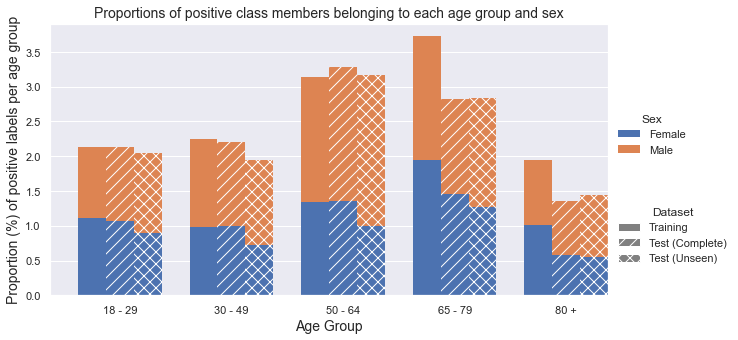

In [47]:
def agesex_barplot(save=None):
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    dfs = {
        'Training': sci_train,
        'Test (Complete)': sci_test,
        'Test (Unseen)': sci_test.loc[unseen_idx]
    }
    for name, df in dfs.items():
        df = df[['AgeBand', 'Female', 'CriticalEvent']].copy()
        series = df.Female.copy()
        df.loc[series, 'Female'] = 'Female'
        df.loc[~series, 'Female'] = 'Male'
        df.loc[df.AgeBand == '17 - 29', 'AgeBand'] = '18 - 29'
        df = df.groupby(['AgeBand', 'Female']).CriticalEvent.sum()/df.groupby(['AgeBand']).CriticalEvent.count()*100
        df = df.drop('16 and Under', level=0).reset_index().pivot(columns=['Female'], values=['CriticalEvent'], index='AgeBand').CriticalEvent
        dfs[name] = df
    plot_clustered_stacked(list(dfs.values()), list(dfs.keys()), ['Sex', 'Dataset'], title='Proportions of positive class members belonging to each age group and sex')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proportion (%) of positive labels per age group')
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

    

agesex_barplot(save=f'{Notebook.IMAGE_DIR}/age_sex_bars.svg')

## NEWS

In [48]:
news_performance_thresholds = {n: get_metrics(
        sci_test.derive_critical_event(within=t, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ) for t, n in [(1, '24h'), (2, '48h'), (999, 'Any')]}
baseline_news_performance = news_performance_thresholds['24h']

In [49]:
functions = {
    'Critical Event': sci_test.derive_critical_event,
    'Mortality':sci_test.derive_death_within,
    'Critical Care': sci_test.derive_critical_care,
}
thresholds = {
    '24h': 1,
    '48h': 2,
    'Any': 999
}

news_performances = [
    (outcome_name, threshold_name, get_metrics(
        function(within=threshold, return_series=True),
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    )) for (outcome_name, function) in functions.items() for (threshold_name, threshold) in thresholds.items()
]
pd.DataFrame([dict(
    Outcome=o,
    Threshold=t,
    AUC=f"{v['AUC']:.2f} ({v['AUC_Lower']:.2f}-{v['AUC_Upper']:.2f})",
    AP=f"{v['AP']:.2f} ({v['AP_Lower']:.2f}-{v['AP_Upper']:.2f})",
) for o, t, v in news_performances])

,Outcome,Threshold,AUC,AP
0,Critical Event,24h,0.80 (0.79-0.82),0.15 (0.13-0.18)
1,Critical Event,48h,0.82 (0.80-0.83),0.23 (0.21-0.26)
2,Critical Event,Any,0.77 (0.76-0.77),0.31 (0.29-0.32)
3,Mortality,24h,0.93 (0.89-0.96),0.17 (0.12-0.24)
4,Mortality,48h,0.92 (0.89-0.93),0.26 (0.22-0.32)
5,Mortality,Any,0.77 (0.75-0.78),0.24 (0.22-0.26)
6,Critical Care,24h,0.78 (0.77-0.80),0.10 (0.09-0.11)
7,Critical Care,48h,0.79 (0.78-0.80),0.12 (0.11-0.13)
8,Critical Care,Any,0.76 (0.75-0.78),0.12 (0.11-0.13)


## Metrics

In [50]:
METRICS, Y_PREDS = load_results(Notebook.SYS_RESULTS_DIR)
Y_PREDS = Y_PREDS.dropna()

In [69]:
from scipy import stats as st
from sklearn.metrics import roc_auc_score, average_precision_score
def bootstrap_difference(y_true, y_score, y_idx, metric, n_resamples=99):
    diff = lambda yt, ys, idx: metric(y_true=yt, y_score=ys) - metric(y_true=yt[idx.astype(bool)], y_score=ys[idx.astype(bool)])
    center = diff(y_true, y_score, y_idx)
    res = st.bootstrap(
        data=(y_true.to_numpy(), y_score, y_idx),
        statistic=diff,
        confidence_level=0.95,
        method="percentile",
        n_resamples=n_resamples,
        vectorized=False,
        paired=True,
        random_state=42,
    )

    return res.confidence_interval.low, center, res.confidence_interval.high

def calculate_metric_diff(y_true, y_preds, y_idx, metrics):
    r = []
    for _ in metrics.to_dict(orient='records'):
        ap_low, ap, ap_up = bootstrap_difference(y_true, y_preds[_['name']], y_idx, average_precision_score)
        auc_low, auc, auc_up = bootstrap_difference(y_true, y_preds[_['name']], y_idx, roc_auc_score)
        r.append(_|dict(
            AP = ap,
            AP_Lower = ap_low,
            AP_Upper = ap_up,
            AUC = auc,
            AUC_Lower = auc_low,
            AUC_Upper = auc_up
        ))

    return pd.DataFrame(r)


In [114]:
METRICS.AP.max()-baseline_news_performance['AP']

0.4062705810386779

In [400]:
def recalc_metrics(y_idx, y_true, y_preds, metrics):
    y_true, y_preds = y_true.loc[y_idx], y_preds.loc[y_idx]
    return pd.DataFrame((
        _|get_metrics(y_true, y_preds[_['name']]>0.1, y_preds[_['name']])
        for _ in metrics.to_dict(orient='records')
    ))

# METRICS_UNSEEN, UNSEEN_METRIC_DIFF = (
#     recalc_metrics(unseen_idx, sci_test.derive_critical_event(within=1, return_series=True), Y_PREDS, METRICS),
#     calculate_metric_diff(sci_test.derive_critical_event(within=1, return_series=True), Y_PREDS, ~sci_test.PatientNumber.isin(sci_train.PatientNumber), METRICS)
# )

In [389]:
UNSEEN_METRIC_DIFF = calculate_metric_diff(sci_test.derive_critical_event(within=1, return_series=True), Y_PREDS, ~sci_test.PatientNumber.isin(sci_train.PatientNumber), METRICS)

In [401]:
METRICS_UNSEEN = recalc_metrics(unseen_idx, sci_test.derive_critical_event(within=1, return_series=True), Y_PREDS, METRICS)

In [405]:
UNSEEN_METRIC_DIFF.AUC.median()

-0.004006996777421334

In [87]:
# with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_unseen.bin', 'wb') as file:
#     pickle.dump((METRICS_UNSEEN, UNSEEN_METRIC_DIFF), file)

with open(f'{Notebook.SYS_RESULTS_DIR}/metrics_unseen.bin', 'rb') as file:
    METRICS_UNSEEN, UNSEEN_METRIC_DIFF = pickle.load(file)

### Tables

In [104]:
def summary_metrics_tables(metrics, estimators=['LightGBM', 'L2Regression']):
    df = metrics[
        (metrics.estimator.isin(estimators)) & 
        (metrics.features.isin(select_feature_groups.keys())) & 
        (metrics.resampler == 'None')
    ]
    #df = METRICS.loc[METRICS[METRICS.estimator.isin(['LightGBM', 'L1Regression', 'LinearSVM']) & METRICS.features.isin(select_feature_groups.keys())].groupby(['estimator', 'features']).AUC.idxmax()]

    for estimator in ['LightGBM', 'L2Regression'] :
        display(pd.DataFrame([dict(
            Estimator=_['estimator'],
            Features=select_feature_groups[_['features']],
            AUC=f"{_['AUC']:.2f} ({_['AUC_Lower']:.2f}-{_['AUC_Upper']:.2f})",
            AP=f"{_['AP']:.2f} ({_['AP_Lower']:.2f}-{_['AP_Upper']:.2f})"
        ) for _ in df[df.estimator==estimator].to_dict(orient='records')]))

summary_metrics_tables(METRICS)

,Estimator,Features,AUC,AP
0,LightGBM,Vitals,0.85 (0.83-0.86),0.19 (0.17-0.22)
1,LightGBM,& Obs,0.88 (0.87-0.89),0.37 (0.33-0.40)
2,LightGBM,& Labs,0.89 (0.87-0.90),0.38 (0.35-0.42)
3,LightGBM,& Notes,0.90 (0.89-0.91),0.38 (0.35-0.42)
4,LightGBM,& Services,0.93 (0.92-0.94),0.56 (0.52-0.59)


,Estimator,Features,AUC,AP
0,L2Regression,Vitals,0.82 (0.80-0.83),0.17 (0.15-0.19)
1,L2Regression,& Obs,0.85 (0.83-0.86),0.31 (0.27-0.34)
2,L2Regression,& Labs,0.85 (0.83-0.86),0.31 (0.28-0.34)
3,L2Regression,& Notes,0.86 (0.85-0.87),0.31 (0.28-0.35)
4,L2Regression,& Services,0.90 (0.89-0.91),0.50 (0.47-0.54)


In [91]:
def summary_metrics_unseen_comparison(metrics, metrics_unseen, estimators=['LightGBM', 'L2Regression']):
    mask = lambda df: df[
        (df.estimator.isin(estimators)) & 
        (df.features.isin(select_feature_groups.keys())) & 
        (df.resampler == 'None')
    ]
    dfs = [('Complete', metrics), ('Unseen', metrics_unseen)]
    df = pd.DataFrame((dict(
            Metric=metric,
            Estimator=pretty_print_models[_['estimator']],
            Features=select_feature_groups[_['features']],
            #Value=f"{_[metric]:.2f} ({_[metric+'_Lower']:.2f}-{_[metric+'_Upper']:.2f})",
            Value=f"{_[metric]:.3f}",
            Dataset=dataset,
        )) for dataset, df in dfs for metric in ('AUC', 'AP') for _ in mask(df).to_dict(orient='records')
    ).sort_values(['Metric', 'Estimator', 'Dataset']).set_index(['Metric', 'Estimator', 'Dataset', 'Features']).unstack()['Value'][select_feature_groups.values()]
    df.columns = list(df.columns)
    return df


summary = summary_metrics_unseen_comparison(METRICS, METRICS_UNSEEN)
summary
#

Vitals  & Obs & Labs & Notes & Services
Metric Estimator Dataset                                         
AP     LR-L2     Complete  0.168  0.307  0.309   0.314      0.504
                 Unseen    0.121  0.277  0.272   0.281      0.464
       LightGBM  Complete  0.191  0.366  0.384   0.384      0.556
                 Unseen    0.145  0.356  0.367   0.367      0.536
AUC    LR-L2     Complete  0.818  0.846  0.848   0.860      0.901
                 Unseen    0.815  0.845  0.843   0.855      0.899
       LightGBM  Complete  0.847  0.878  0.886   0.897      0.929
                 Unseen    0.845  0.881  0.886   0.898      0.928

In [92]:
print(summary.to_latex(bold_rows=True, escape=False, column_format='lll|ccccc', multirow=True, formatters=[lambda x: f'${x}$' for _ in range(5)]))

\begin{tabular}{lll|ccccc}
\toprule
    &          &        &   Vitals &    & Obs &   & Labs &  & Notes & & Services \\
\textbf{Metric} & \textbf{Estimator} & \textbf{Dataset} &          &          &          &          &            \\
\midrule
\multirow{4}{*}{\textbf{AP}} & \multirow{2}{*}{\textbf{LR-L2}} & \textbf{Complete} &  $0.168$ &  $0.307$ &  $0.309$ &  $0.314$ &    $0.504$ \\
    &          & \textbf{Unseen} &  $0.121$ &  $0.277$ &  $0.272$ &  $0.281$ &    $0.464$ \\
\cline{2-8}
    & \multirow{2}{*}{\textbf{LightGBM}} & \textbf{Complete} &  $0.191$ &  $0.366$ &  $0.384$ &  $0.384$ &    $0.556$ \\
    &          & \textbf{Unseen} &  $0.145$ &  $0.356$ &  $0.367$ &  $0.367$ &    $0.536$ \\
\cline{1-8}
\cline{2-8}
\multirow{4}{*}{\textbf{AUC}} & \multirow{2}{*}{\textbf{LR-L2}} & \textbf{Complete} &  $0.818$ &  $0.846$ &  $0.848$ &  $0.860$ &    $0.901$ \\
    &          & \textbf{Unseen} &  $0.815$ &  $0.845$ &  $0.843$ &  $0.855$ &    $0.899$ \\
\cline{2-8}
    & \multirow{2}{*

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [85]:
def news_summary_metrics():
    y_test = sci_test.derive_critical_event(within=1, return_series=True)
    metrics = [get_metrics(
        y_test,
        sci_test.NEWS_score >= 7,
        sci_test.NEWS_score
    ), get_metrics(
        y_test.loc[unseen_idx],
        sci_test.loc[unseen_idx].NEWS_score >= 7,
        sci_test.loc[unseen_idx].NEWS_score
    )]
    metrics = [_|dict(
        name='NEWS2',
        estimator='NEWS2',
        resampler=None,
        features='NEWS2',
        outcome_within=1
    ) for _ in metrics]
    metrics_diff = calculate_metric_diff(y_test, {'NEWS2': sci_test.NEWS_score}, ~sci_test.PatientNumber.isin(sci_train.PatientNumber), pd.DataFrame(metrics[0], index=[0])).to_dict(orient='records')[0]

    dfs = {'Test (Complete)': metrics[0], 'Test (Unseen)': metrics[1], 'Delta': metrics_diff}
    r = [dict(
        Data=dfname,
        Metric=metric,
        Estimator=_['estimator'],
        Features=_['features'],
        Summary=f'{_[metric]:.5f} ({_[metric+"_Lower"]:.5f}-{_[metric + "_Upper"]:.5f})',
    ) for dfname, _ in dfs.items() for metric in ('AUC', 'AP')]
    return r

In [90]:
def summary_metrics_unseen_comparison(metrics, metrics_unseen, metrics_diff):
    dfs = {'Test (Complete)': metrics, 'Test (Unseen)': metrics_unseen, 'Delta': metrics_diff}
    dfs = {k: v[(v.resampler=='None')&(v.features.isin(select_feature_groups.keys()))] for k, v in dfs.items()}
    group_names = select_feature_groups | select_scored_feature_groups
    r = [dict(
        Data=dfname,
        Metric=metric,
        Estimator=pretty_print_models[_['estimator']],
        Features=group_names[_['features']],
        Summary=f'{_[metric]:.5f} ({_[metric+"_Lower"]:.5f}-{_[metric + "_Upper"]:.5f})',
    ) for dfname, df in dfs.items() for _ in df.to_dict(orient='records') for metric in ('AUC', 'AP')]
    r = news_summary_metrics() + r
    return pd.DataFrame(r).pivot(index=['Features', 'Estimator'], columns=['Metric', 'Data'], values='Summary').loc[['NEWS2', 'Vitals', '& Obs', '& Labs', '& Notes', '& Services']][['AUC', 'AP']]

r = summary_metrics_unseen_comparison(METRICS, METRICS_UNSEEN, UNSEEN_METRIC_DIFF)#.set_index(['Estimator', 'Features', 'Metric', 'Data', 'Resampler'])
r

Metric                                                   AUC  \
Data                                         Test (Complete)   
Features         Estimator                                     
Reference (NEWS) Reference (NEWS)  0.80192 (0.78649-0.81777)   
Vitals           LR                0.81849 (0.80227-0.83370)   
                 LR-EN             0.81775 (0.80155-0.83293)   
                 LR-L1             0.81800 (0.80200-0.83311)   
                 LR-L2             0.81763 (0.80172-0.83296)   
                 LightGBM          0.84720 (0.83393-0.86070)   
                 LinearSVM         0.81586 (0.79976-0.83176)   
                 XGBoost           0.84843 (0.83479-0.86133)   
& Obs            LR                0.84633 (0.83208-0.85929)   
                 LR-EN             0.84636 (0.83213-0.85941)   
                 LR-L1             0.84641 (0.83217-0.85946)   
                 LR-L2             0.84642 (0.83215-0.85946)   
                 LightGBM          0.87777 (0.86611-0.88955)   
                 LinearSVM         0.81276 (0.79551-0.82794)   
                 XGBoost           0.88138 (0.86992-0.89250)   
& Labs           LR                0.84843 (0.83476-0.86184)   
                 LR-EN             0.84842 (0.83473-0.86178)   
                 LR-L1             0.84847 (0.83482-0.86179)   
                 LR-L2             0.84841 (0.83481-0.86180)   
                 LightGBM          0.88572 (0.87398-0.89726)   
                 LinearSVM         0.81012 (0.79602-0.82385)   
                 XGBoost           0.87941 (0.86714-0.89056)   
& Notes          LR                0.85798 (0.84440-0.87041)   
                 LR-EN             0.86042 (0.84779-0.87251)   
                 LR-L1             0.86030 (0.84748-0.87230)   
                 LR-L2             0.86031 (0.84770-0.87224)   
                 LightGBM          0.89690 (0.88600-0.90778)   
                 LinearSVM         0.82904 (0.81515-0.84264)   
                 XGBoost           0.89455 (0.88275-0.90530)   
& Services       LR                0.89811 (0.88548-0.90904)   
                 LR-EN             0.90460 (0.89366-0.91532)   
                 LR-L1             0.90076 (0.88895-0.91125)   
                 LR-L2             0.90117 (0.88947-0.91170)   
                 LightGBM          0.92913 (0.91987-0.93798)   
                 LinearSVM         0.86805 (0.85327-0.88145)   
                 XGBoost           0.92810 (0.91878-0.93695)   

Metric                                                        \
Data                                           Test (Unseen)   
Features         Estimator                                     
Reference (NEWS) Reference (NEWS)  0.81519 (0.79288-0.83345)   
Vitals           LR                0.82527 (0.80216-0.84084)   
                 LR-EN             0.82497 (0.80146-0.84034)   
                 LR-L1             0.82522 (0.80207-0.84099)   
                 LR-L2             0.82474 (0.80132-0.84027)   
                 LightGBM          0.85082 (0.83296-0.86455)   
                 LinearSVM         0.82150 (0.79808-0.83714)   
                 XGBoost           0.85366 (0.83511-0.86646)   
& Obs            LR                0.84857 (0.82939-0.86403)   
                 LR-EN             0.84876 (0.82956-0.86416)   
                 LR-L1             0.84886 (0.82966-0.86432)   
                 LR-L2             0.84878 (0.82966-0.86430)   
                 LightGBM          0.88318 (0.86724-0.89986)   
                 LinearSVM         0.81593 (0.79657-0.83073)   
                 XGBoost           0.88756 (0.87332-0.90110)   
& Labs           LR                0.85043 (0.83120-0.86241)   
                 LR-EN             0.85034 (0.83121-0.86244)   
                 LR-L1             0.85036 (0.83120-0.86240)   
                 LR-L2             0.85034 (0.83107-0.86235)   
                 LightGBM          0.88941 (0.87195-0.90144)   
                 LinearSVM     

In [92]:
print(r['AUC'].to_latex(bold_rows=True, multirow=True, multicolumn=True, longtable=False, column_format='llrrrrrr'))

\begin{tabular}{llrrrrrr}
\toprule
           & \textbf{Data} &            Test (Complete) &              Test (Unseen) &                         Delta \\
\textbf{Features} & \textbf{Estimator} &                            &                            &                               \\
\midrule
\textbf{Reference (NEWS)} & \textbf{Reference (NEWS)} &  0.80192 (0.78649-0.81777) &  0.81519 (0.79288-0.83345) &  -0.01328 (-0.02463--0.00335) \\
\multirow{7}{*}{\textbf{Vitals}} & \textbf{LR} &  0.81849 (0.80227-0.83370) &  0.82527 (0.80216-0.84084) &   -0.00679 (-0.01760-0.00649) \\
           & \textbf{LR-EN} &  0.81775 (0.80155-0.83293) &  0.82497 (0.80146-0.84034) &   -0.00722 (-0.01803-0.00632) \\
           & \textbf{LR-L1} &  0.81800 (0.80200-0.83311) &  0.82522 (0.80207-0.84099) &   -0.00722 (-0.01790-0.00622) \\
           & \textbf{LR-L2} &  0.81763 (0.80172-0.83296) &  0.82474 (0.80132-0.84027) &   -0.00711 (-0.01824-0.00612) \\
           & \textbf{LightGBM} &  0.84720 (0.83393-0.8

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


### Bar Plots

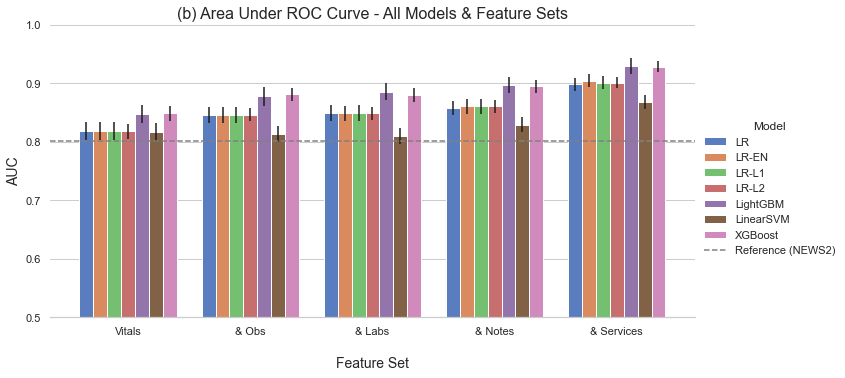

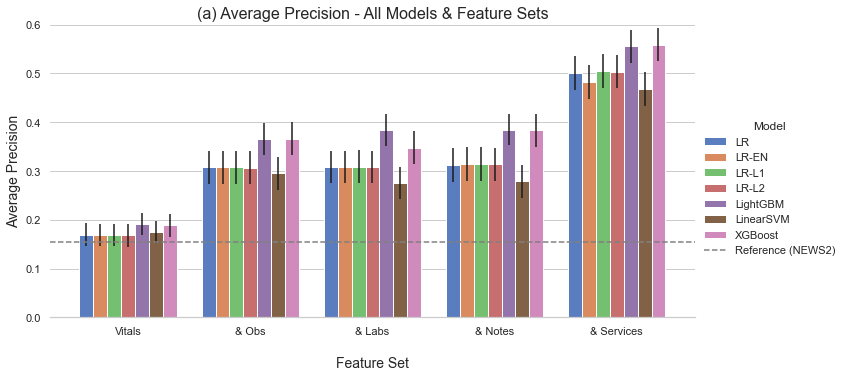

In [93]:
def select_feature_ablation_barplot(metrics, feature_groups, metric='AUC', ylim=(0.0, 1.0), ylabel=None, baseline=None, title=None, save=None):
    sns.set_style('whitegrid')
    df = metrics[
        (metrics.features.isin(feature_groups.keys()))
        & (metrics.resampler == 'None')
    ].rename(columns=dict(
        features='Features',
        estimator='Model'
    ))
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df['Features'] = pd.Categorical(df.Features.replace(feature_groups), ordered=True, categories=feature_groups.values())
    df['Model'] = df.Model.replace(pretty_print_models)
    g = sns.catplot(
        data=df.sort_values(['Model','Features']), x='Features', y=metric, hue='Model',
        kind='bar', palette='muted', height=6, orient='v', legend=False
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    g.ax.set_ylim(ylim)
    x_coords = [p.get_x() + 0.5*p.get_width() for p in g.ax.patches]
    y_coords = [p.get_height() for p in g.ax.patches]
    g.ax.errorbar(x=x_coords, y=y_coords, yerr=err, fmt="none", c= "k")

    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "Reference (NEWS2)") 
        g.add_legend(title='Model')
    
    g.set_xlabels("Feature Set", labelpad=20)
    g.ax.set_title(title, fontsize=16)
    if ylabel:
        g.set_ylabels(ylabel)
    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

select_feature_ablation_barplot(METRICS, select_feature_groups, 'AUC', (0.5, 1.0), baseline=baseline_news_performance, ylabel='AUC', title='(b) Area Under ROC Curve - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/auc_bar.svg')
select_feature_ablation_barplot(METRICS, select_feature_groups, 'AP', (0.0, 0.6), baseline=baseline_news_performance, ylabel='Average Precision', title='(a) Average Precision - All Models & Feature Sets', save=f'{Notebook.IMAGE_DIR}/ap_bar.svg')

### Precision-Recall

In [97]:
test_set_n_days = (
    sci.loc[sci_test.index].AdmissionDateTime.max()
    - sci.loc[sci_test.index].AdmissionDateTime.min()
).days

In [57]:
def model_preds_across_features(metrics, y_preds, estimator='LightGBM'):
    metrics_l = metrics[(metrics.estimator == estimator) & (metrics.features.isin(select_feature_groups.keys())) & (metrics.resampler == 'None') & (metrics.outcome_within == 1)]
    y_preds_l = y_preds[metrics_l.name]
    y_preds_l.columns=metrics_l.features.replace(select_feature_groups)
    y_preds_l = y_preds_l.to_dict(orient='list')

    return y_preds_l

def all_model_preds(metrics, y_preds, features='with_notes_labs_and_hospital'):
    metrics_r = metrics.loc[
        metrics[(metrics.features==features) & (metrics.outcome_within==1)].groupby('estimator').AP.idxmax()
    ]

    y_preds_r = y_preds[metrics_r.name]
    y_preds_r.columns=metrics_r.estimator
    y_preds_r.columns = y_preds_r.columns.map(pretty_print_models)
    y_preds_r = y_preds_r[sorted(y_preds_r.columns)]
    y_preds_r = y_preds_r.to_dict(orient='list')

    return y_preds_r

def calib_curves(metrics, y_preds, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    y_preds_l, y_preds_r = model_preds_across_features(metrics, y_preds, 'XGBoost'), all_model_preds(metrics, y_preds)

    plot_calibration_curves(y_test, y_preds_l, ax=ax[0], title='(a) GBDT (LightGBM)')
    plot_calibration_curves(y_test, y_preds_r, ax=ax[1], title='(b) All Models, Complete Feature Set')

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle('Model Calibration')
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
   

calib_curves(METRICS, Y_PREDS)

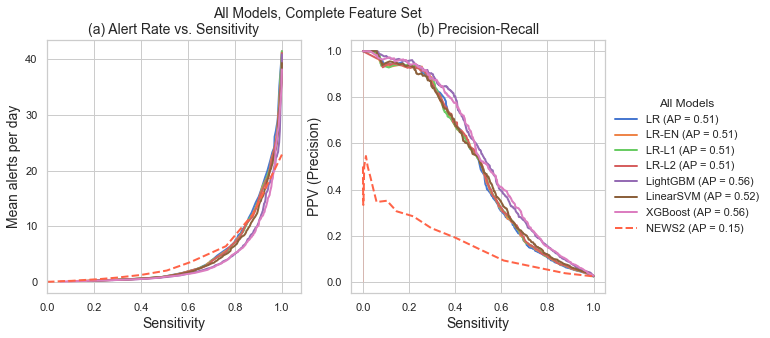

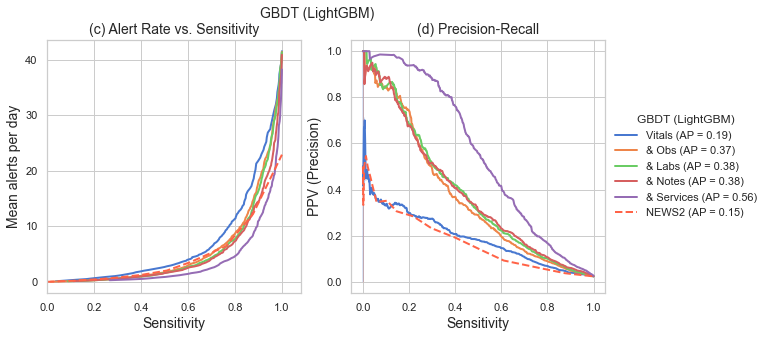

In [105]:
def pr_alert_curves(metrics, y_preds, data_function=model_preds_across_features, title='GBDT (LightGBM)', legend='GBDT (LightGBM)', save=None, debug=False, subtitles=['Alert Rate vs. Sensitivity', 'Precision-Recall']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    if debug:
        y_preds = y_preds.sample(1000)

    y_preds_l = data_function(metrics, y_preds)
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
    
    with sns.color_palette('muted'):
        plot_pr_curves(y_test, y_preds_l | baseline_news, smoothing=(not debug), ax=ax[1], palette=sns.color_palette('muted'), baseline_key='NEWS2', title=subtitles[1])
        plot_alert_rate(y_test, y_preds_l | baseline_news, test_set_n_days, ax=ax[0], intercepts=False, baseline_key='NEWS2', title=subtitles[0])

        
    sns.move_legend(ax[1], "center left", bbox_to_anchor=(1, 0.5), frameon=False, title=legend)
    ax[0].legend([], [], frameon=False)
    
    fig.subplots_adjust(top=0.95)
    fig.suptitle(title, fontsize=14)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

pr_alert_curves(
    METRICS, Y_PREDS, all_model_preds, 
    title='All Models, Complete Feature Set', legend='All Models', 
    subtitles=['(a) Alert Rate vs. Sensitivity', '(b) Precision-Recall'],
    save=f'{Notebook.IMAGE_DIR}/alert_pr_all.svg'
)
pr_alert_curves(
    METRICS, Y_PREDS, model_preds_across_features, 
    title='GBDT (LightGBM)', legend='GBDT (LightGBM)', 
    subtitles=['(c) Alert Rate vs. Sensitivity', '(d) Precision-Recall'],
    save=f'{Notebook.IMAGE_DIR}/alert_pr_lightgbm.svg'
)

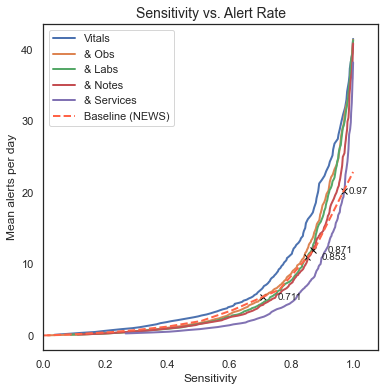

In [ ]:
y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[Y_PREDS.index]
baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
plot_alert_rate(y_test, model_preds_across_features(METRICS, Y_PREDS) | baseline_news, test_set_n_days, intercepts=True, baseline_key='NEWS2')

In [104]:
y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[Y_PREDS.index]
baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
    sci_test.derive_critical_event(return_series=True, within=1),
    baseline_news['NEWS2'],
    Y_PREDS["LightGBM_None_Within-1_with_notes_labs_and_hospital"],
    test_set_n_days,
)
print(
    f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
)

At sensitivity ~0.877: NEWS Alert rate: 12.168, LGBM Alert rate: 8.441 -> 30.631% less


## Sub-scores

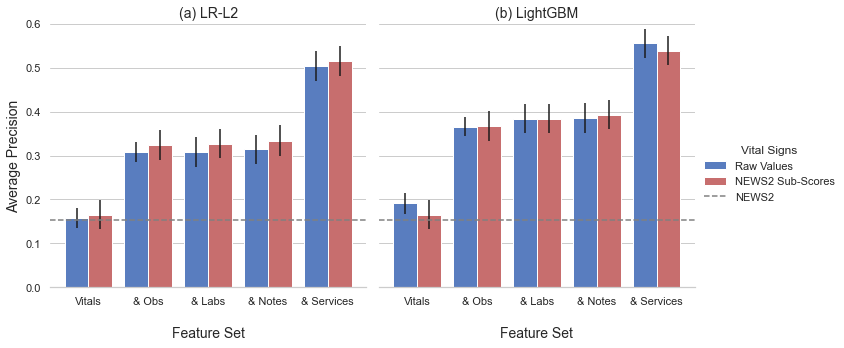

In [107]:
def subscores_barplot(metrics, feature_groups, scored_feature_groups, metric='AP', ylim=(0.0, 0.6), baseline=None, save=None):
    df = metrics[(metrics.estimator.isin(['LightGBM', 'L2Regression'])) & (metrics.resampler=='None')].copy()
    
    df['Vital Signs'] = df['features'].isin(scored_feature_groups.keys()).map({
        True:'NEWS2 Sub-Scores',
        False:'Raw Values'
    })
    df.loc[(df.estimator == 'L2Regression')&(df.features=='news'), metric] -= 0.010
    
    df['features'] = df.features.map(feature_groups | scored_feature_groups)
    err = (df[f'{metric}_Upper']-df[f'{metric}_Lower'])/2
    df = df.rename(columns=dict(
        features='Features',
        estimator='Model',
    ))
    df['Model'] = df.Model.replace(dict(
        L2Regression='(a) LR-L2',
        LightGBM = '(b) LightGBM'
    ))

    sns.set_style('whitegrid')

    g = sns.catplot(
        data=df, x='Features', y=metric, hue='Vital Signs', col='Model',
        kind='bar', palette=[sns.color_palette('muted')[0], sns.color_palette('muted')[3]], height=6, orient='v', legend=False, 
    )
    g.despine(left=True)
    g.fig.set_size_inches(10,5)
    subp = [(i, model, ax) for i, (model, ax) in enumerate(g.axes_dict.items())]
    for i, model, ax in subp:
        ax.set_ylim(ylim)
        x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(x=x_coords, y=y_coords, yerr=err[(df.Model==model)], fmt="none", c= "k")
    g.set_xlabels("Feature Set", labelpad=20, fontsize=14)
    g.set_ylabels('Average Precision', fontsize=14)
    if baseline is not None:
        g.refline(y = baseline[metric], color = 'gray', linestyle = '--', label = "NEWS2") 
        g.add_legend(title='Vital Signs')
    
    g.set_titles(template='{col_name}', size=14)

    if save:
        plt.savefig(save, bbox_inches="tight", format='svg')

subscores_barplot(METRICS, select_feature_groups, select_scored_feature_groups, baseline=baseline_news_performance, save=f'{Notebook.IMAGE_DIR}/raw_vs_scored_ap.svg')


## LR Coefficients

In [84]:
from utils.evaluation import get_calibrated_regression_coefficients, regression_coefficient_sorted_barplot
def get_coefficients(name, onehot_cols=None, directory=Notebook.SYS_RESULTS_DIR):
    if onehot_cols is None:
        X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
        onehot_cols = X_train.get_onehot_categorical_columns()
    
    model, *_ = load_model(name, directory)
    coef = get_calibrated_regression_coefficients(
        model, model.feature_names_in_, name.split('_')[0]
    ).set_index('Feature').Coefficient

    cat_cols = select_categorical_cols | dict(AdmissionMethod='Admission Pathway')

    coef_num = coef[~coef.index.isin([__ for _ in onehot_cols.values() for __ in _])].sort_values()
    coef_cat = pd.DataFrame([dict(
        Feature=cat_cols[key],
        Value=_,
        Coef=coef.loc[_]    
    ) for key, val in onehot_cols.items() for _ in val if _ in coef.index])
    coef_cat.Value = coef_cat.Value.str.split('__').str[1]

    return coef_num, coef_cat

#coef_num, coef_cat = get_coefficients('L1Regression_None_Within-1_with_notes_labs_and_hospital')

In [ ]:
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
onehot_cols = X_train.get_onehot_categorical_columns()

In [ ]:
def categorical_coefficient_table(onehot_cols, estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, within=1):
    r = pd.concat((
        get_coefficients(
            f'{estimator}_None_Within-{within}_{feature_group}', onehot_cols, directory=directory
        )[1].assign(Model=pretty_print_models[estimator]).replace('NAN', 'Unknown')
    ) for estimator in estimators)
    r.Value = r.Value.replace(pretty_print_categoricals)
    top = r.copy()
    top.Coef = top.Coef.apply(abs)
    top = top.groupby(['Feature', 'Value']).mean().groupby('Feature').Coef.nlargest(5).droplevel(0).index
    return r.pivot(index=['Feature', 'Value'], columns='Model', values='Coef').loc[top].round(4)

cat_coef = categorical_coefficient_table(onehot_cols)
cat_coef

Model                                           LR   LR-EN   LR-L1   LR-L2
Feature              Value                                                
A&E Diagnosis        dementia              -6.1432 -1.7451 -1.2943 -0.9013
                     dizz                  -4.9684 -1.1038 -0.5838 -0.5159
                     Unknown                1.2753  0.7601  0.5259  0.6802
                     collaps-               0.9634  0.6004  0.2107  0.3663
                     mobility              -0.6437 -1.0255 -0.2258 -0.1658
Admission Pathway    Emg. Tran. Oth. Prov.  1.0949  1.7971  1.5135  1.7077
                     Elective Booked       -2.9414 -0.9551 -1.2917 -0.8593
                     Emg. OPD              -1.8238 -0.6519 -1.3002 -0.8997
                     Booked Adm.           -1.5656 -0.5976 -1.0964 -0.7702
                     Emg. A&E               0.3737  1.1025  0.8288  1.0903
Admission Specialty  General Med.           6.2128  5.1825  4.4975  4.2733
                     Respiratory Med.       5.8984  4.3095  4.1729  3.8469
                     Geriatric Med.         5.3137  3.4662  3.5696  3.1702
                     Bariatric Surg.        8.5721  2.0854  2.4279  1.7563
                     Spinal Surg. Svc.     -6.3536 -2.7242 -2.2012 -1.5710
Breathing Device     NHF                    3.0114  3.2644  3.0935  2.9339
                     NIV - NIV              2.6470  2.6736  2.7448  2.6523
                     Unknown               -6.2554 -1.0489 -1.4830 -0.6653
                     V40 - Venturi 40%     -1.2336 -1.0602 -1.1222 -1.1587
                     H40 - Humidified 40%   0.9526  1.6357  1.0160  0.9178
Presenting Complaint facial problems       -5.9395 -2.4239 -1.5906 -1.1547
                     ear problems          -6.3951 -1.5335 -1.6616 -1.2192
                     testicular pain       -5.2260 -1.7206 -0.9948 -0.7995
                     gi bleeding            2.9069  2.0813  1.7701  1.7223
                     pneumonia             -5.1187 -1.6404 -0.9275 -0.7593

In [ ]:
print(cat_coef.to_latex(bold_rows=True, multirow=True, column_format='llrrrr'))

\begin{tabular}{llrrrr}
\toprule
                     & \textbf{Model} &      LR &   LR-EN &   LR-L1 &   LR-L2 \\
\textbf{Feature} & \textbf{Value} &         &         &         &         \\
\midrule
\multirow{5}{*}{\textbf{A\&E Diagnosis}} & \textbf{dementia} & -6.1432 & -1.7451 & -1.2943 & -0.9013 \\
                     & \textbf{dizz} & -4.9684 & -1.1038 & -0.5838 & -0.5159 \\
                     & \textbf{Unknown} &  1.2753 &  0.7601 &  0.5259 &  0.6802 \\
                     & \textbf{collaps-} &  0.9634 &  0.6004 &  0.2107 &  0.3663 \\
                     & \textbf{mobility} & -0.6437 & -1.0255 & -0.2258 & -0.1658 \\
\cline{1-6}
\multirow{5}{*}{\textbf{Admission Pathway}} & \textbf{Emg. Tran. Oth. Prov.} &  1.0949 &  1.7971 &  1.5135 &  1.7077 \\
                     & \textbf{Elective Booked} & -2.9414 & -0.9551 & -1.2917 & -0.8593 \\
                     & \textbf{Emg. OPD} & -1.8238 & -0.6519 & -1.3002 & -0.8997 \\
                     & \textbf{Booked Adm.} & -1.5656 & -0

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [ ]:
def numerical_coefficient_table(estimators=['LogisticRegression', 'L1Regression', 'L2Regression', 'ElasticNetRegression'], feature_group='with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, within=1):
    X_train, X_test, y_train, y_test = get_xy(scii, Estimator_L1Regression, scii.feature_group_combinations['with_notes_labs_and_hospital'])
    onehot_cols = X_train.get_onehot_categorical_columns()

    r = pd.concat((
        (
            get_coefficients(f'{_}_None_Within-{within}_{feature_group}', onehot_cols, directory=directory)[0]
            .set_index('Feature').Coefficient.rename(_)
        ) for _ in estimators), axis=1
    ).round(4).T

    r.columns = map(SCICols.pretty_print_columns.get, r.columns)
    r.index = map(pretty_print_models.get, r.index)
    return r

coef = numerical_coefficient_table()
coef.T

,LR,LR-L1,LR-L2,LR-EN
Sent To SDEC,-1.0865,-1.0877,-1.0878,-0.9591
Sodium,-0.8163,-0.8164,-0.8092,-1.5574
Age,-0.5663,-0.5640,-0.5632,-0.5590
FiO2,-0.4445,-0.4436,-0.4415,-0.4870
SpO2,-0.2000,-0.1997,-0.1999,-0.2984
Creatinine,-0.1856,-0.1841,-0.1840,-0.2454
Assisted Breathing,-0.1295,-0.1284,-0.1286,-0.1246
Readmission,-0.1105,-0.1116,-0.1116,0.0238
Temperature,-0.0532,-0.0528,-0.0523,-0.0686
Alert (AVCPU),-0.0448,-0.0410,-0.0397,0.0163


In [ ]:
print(coef.T.to_latex(bold_rows=True, column_format='lrrrr',  formatters=[lambda x: f'${x}$' for _ in range(4)], escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &        LR &     LR-L1 &     LR-L2 &     LR-EN \\
\midrule
\textbf{Sent To SDEC      } & $-1.0865$ & $-1.0877$ & $-1.0878$ & $-0.9591$ \\
\textbf{Sodium            } & $-0.8163$ & $-0.8164$ & $-0.8092$ & $-1.5574$ \\
\textbf{Age               } & $-0.5663$ &  $-0.564$ & $-0.5632$ &  $-0.559$ \\
\textbf{FiO2              } & $-0.4445$ & $-0.4436$ & $-0.4415$ &  $-0.487$ \\
\textbf{SpO2              } &    $-0.2$ & $-0.1997$ & $-0.1999$ & $-0.2984$ \\
\textbf{Creatinine        } & $-0.1856$ & $-0.1841$ &  $-0.184$ & $-0.2454$ \\
\textbf{Assisted Breathing} & $-0.1295$ & $-0.1284$ & $-0.1286$ & $-0.1246$ \\
\textbf{Readmission       } & $-0.1105$ & $-0.1116$ & $-0.1116$ &  $0.0238$ \\
\textbf{Temperature       } & $-0.0532$ & $-0.0528$ & $-0.0523$ & $-0.0686$ \\
\textbf{Alert (AVCPU)     } & $-0.0448$ &  $-0.041$ & $-0.0397$ &  $0.0163$ \\
\textbf{Systolic BP       } & $-0.0216$ & $-0.0226$ & $-0.0225$ & $-0.0031$ \\
\textbf{Urea              } &  $0.00

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## SHAP

In [ ]:
from utils.evaluation import plot_shap_features_joint, plot_calibrated_regression_coefficients

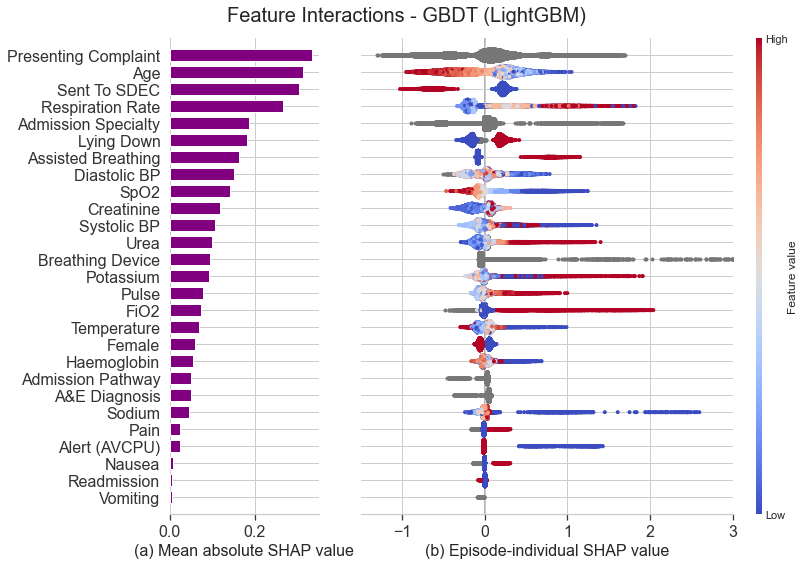

In [131]:
def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )
    
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm.png')

In [ ]:
def categorical_shap_table_lgbm():
    _, explanations, *_ = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
    common = [_ for _ in explanations.feature_names if _ in select_categorical_cols.keys()]
    r = []
    for feature in common:
        idx = explanations.feature_names.index(feature)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(6).index
        r.append(df.mean().loc[selected].sort_values().rename(select_categorical_cols[feature]))
    return pd.concat([_.reset_index() for _ in r], axis=1)

categorical_shap_table_lgbm()

,Data,Breathing Device,Data,Presenting Complaint,Data,A&E Diagnosis,Data,Admission Pathway,Data,Admission Specialty
0,TM - Tracheostomy mask,1.348878,back pain,-1.012240,head,-0.246121,EMERGENCY GP REFER,-0.339962,GENERAL SURGERY,0.921266
1,Other,1.363480,facial problems,-0.866434,pain,-0.225264,EMERGENCY OPD,-0.279905,UROLOGY,1.130922
2,CPAP - CPAP,1.457433,asthma,0.878512,cope,-0.214821,BOOKED ADMISSION,-0.277418,STROKE NEUROLOGY,1.442393
3,H40 - Humidified 40%,1.610166,major trauma,0.980837,vomit,-0.122562,ELECTIVE PLANNED,-0.080516,GERIATRIC MEDICINE,3.687864
4,NHF,2.724613,gi bleeding,1.345432,diarrh,-0.049148,NON EM TRAN OTH PROV,-0.028658,RESPIRATORY MEDICINE,4.464663
5,NIV - NIV,2.823916,diabetes,1.376302,NaN,0.043622,EMERGENCY A+E,0.025536,GENERAL MEDICINE,4.714054


In [ ]:
def categorical_shap_bars_lgbm():
    _, explanations, *_ = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
    common = [_ for _ in explanations.feature_names if _ in select_categorical_cols.keys()]
    r = []
    for feature in common:
        idx = explanations.feature_names.index(feature)
        df = pd.DataFrame(
            zip(explanations[:, idx].values, explanations[:, idx].data), 
            columns=['Value', 'Data']).pivot(columns='Data').Value
        selected = df.apply(abs).mean().sort_values().tail(10).index
        r.append(df.mean().loc[selected].sort_values().rename('SHAP').to_frame().assign(Feature=select_categorical_cols[feature]))

    return pd.concat(r).reset_index()

categorical_shap_bars_lgbm()

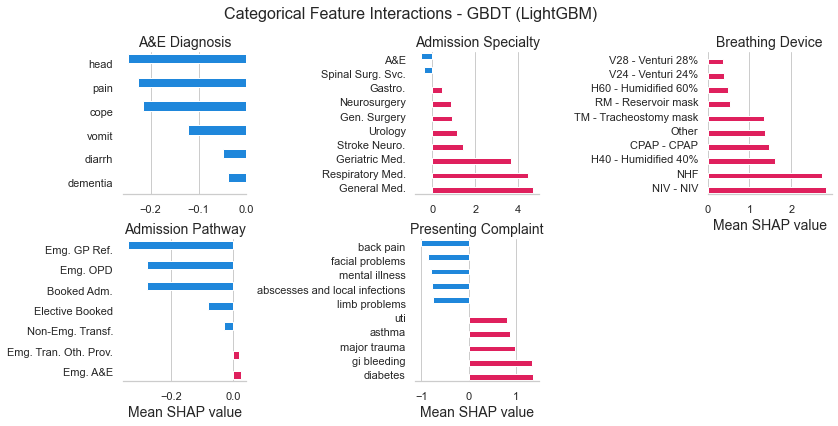

In [ ]:
df['Hue'] = (df.SHAP > 0).astype(int)
sns.set_style('whitegrid')
g = sns.catplot(
    data=df, x='SHAP', y='Data', col='Feature', hue='Hue', palette=[shap.plots.colors.blue_rgb, shap.plots.colors.red_rgb],
    kind='bar', orient='h', sharey=False, sharex=False, legend=False, col_wrap=3, 
    col_order=['A&E Diagnosis', 'Admission Specialty', 'Breathing Device', 'Admission Pathway', 'Presenting Complaint']
)
g.set_titles(template='{col_name}')
g.fig.set_size_inches(12,6)
g.fig.tight_layout()
g.set_ylabels('')
g.set_xlabels('Mean SHAP value')
g.despine(left=True)
g.fig.suptitle('Categorical Feature Interactions - GBDT (LightGBM)')
g.fig.subplots_adjust(top=0.875)
plt.savefig(f'{Notebook.IMAGE_DIR}/shap_categorical.svg', bbox_inches='tight', format='svg')

### Age & Sex

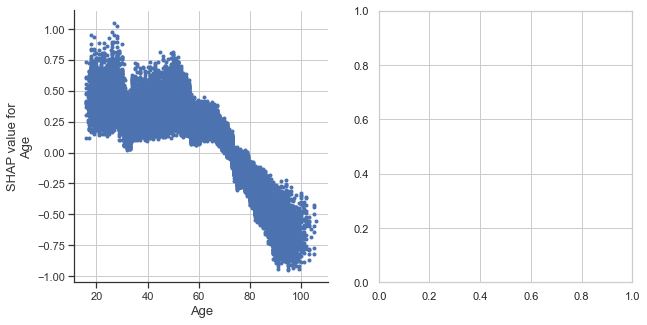

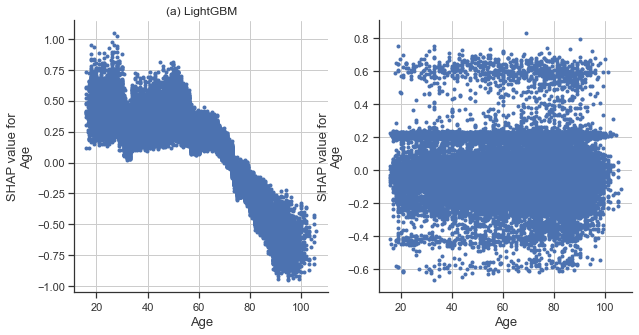

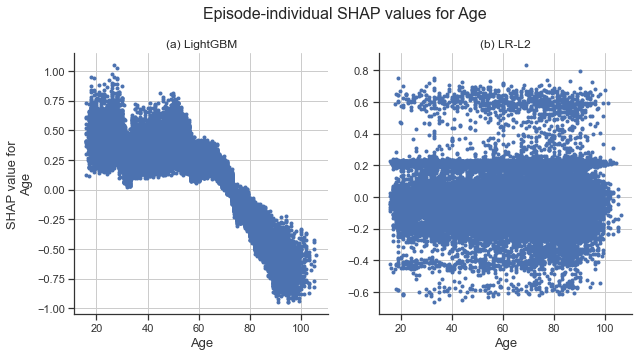

In [26]:
def comparison_scatter_plots(feature='Age', models=['LightGBM', 'L2Regression'], directory=Notebook.SYS_RESULTS_DIR, save=None, title=None, color='b', letters='ab'):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    for i, model in enumerate(models):
        _, explanations, *_ = load_model(f'{model}_None_Within-1_with_notes_labs_and_hospital', directory)
        explanations = explanations[:,explanations.feature_names.index(feature)]
        if feature == 'Temperature':
            mask = explanations.data > 34
            explanations.data = explanations.data[mask]
            explanations.values = explanations.values[mask]
        shap.plots.scatter(explanations, hist=False, ax=ax[i], color=color)
        ax[i].set_title(f'({letters[i]}) {pretty_print_models[model]}')
        if i > 0:
            ax[i].set_ylabel('')
    if not title:
        title = f'Episode-individual SHAP values for {feature}'
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)
    if save:
        fig.savefig(save, bbox_inches='tight', format='svg')
    return fig
    
comparison_scatter_plots(save=f'{Notebook.IMAGE_DIR}/shap_scatter_age.svg')

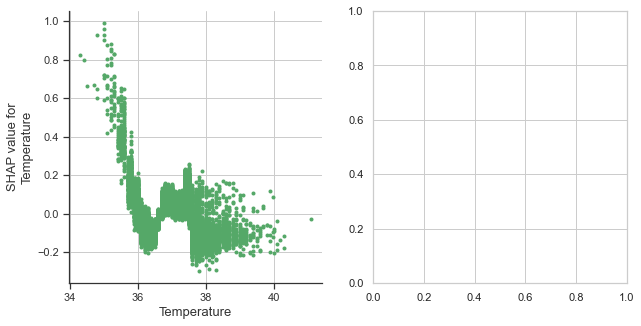

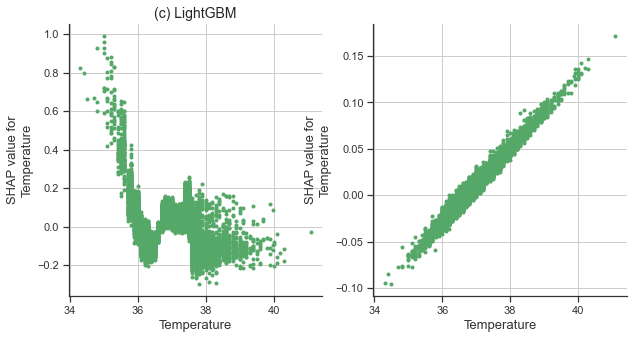

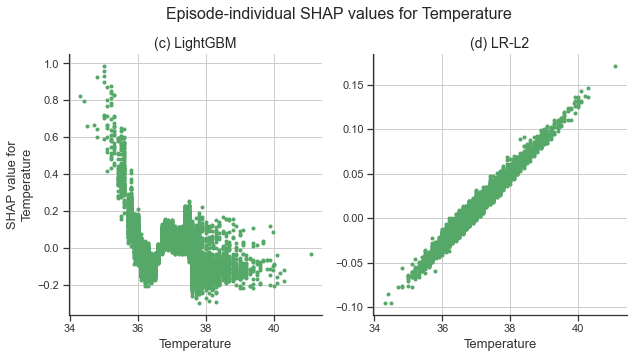

In [29]:
comparison_scatter_plots(feature='Temperature', save=f'{Notebook.IMAGE_DIR}/shap_scatter_temperature.svg', color='g', letters='cd')

### Misclassifications

In [135]:
from sklearn.metrics import precision_recall_curve

X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LightGBM, scii.feature_group_combinations['with_notes_labs_and_hospital'])
_, recall, thresholds = precision_recall_curve(y_test, Y_PREDS['LightGBM_None_Within-1_with_notes_labs_and_hospital'])

Int64Index([  8306,  22491,   1119,  27258,  94625,   5750,  93864, 100498,
            128649, 125973,  16934, 120325, 117603,  28061,  29804, 151516,
            133076,  94635,  62894,   4876,  67391,  35906,  28630, 136882,
             72523, 102554,  21850,  93141,  41788,  72888, 110336,  30971,
            149072,  66645,  93862,  90741,   4852, 143951,  16177, 144608,
            113509, 145703,   1460,  87529,  70552,  26432,  23642,  16933,
            146586,  70721,  88077,  38264, 102878, 122625,  99260,  93015,
             80359,  87100, 117376, 126105, 102438,  69974, 102193,  89830,
             29003,  82547,  93806,  86615, 107265,  40957,  31119,  60620,
             69137, 111173,  70598,  61692,  15695,  83196, 123214,  20036,
             58355, 137204, 151858,  72577,  26214,  12163,  78059,  89006,
             89479,   4140,  11671,  88759, 125782],
           dtype='int64')

In [183]:
sci_test[((y_pred_proba < thresholds[np.abs(recall-0.90).argmin()]) & y_test)].AandEPresentingComplaint.value_counts()

other                            24
shortness of breath in adults    15
chest pain                       12
abdominal pain in adults          5
limb problems                     3
headache                          2
mental illness                    2
falls                             2
back pain                         2
overdose and poisoning            2
gi bleeding                       1
palpitations                      1
behaving strangely                1
head injury                       1
allergy                           1
fits                              1
major trauma                      1
diarrhoea and vomiting            1
facial problems                   1
abnormal bloods                   1
Name: AandEPresentingComplaint, dtype: int64

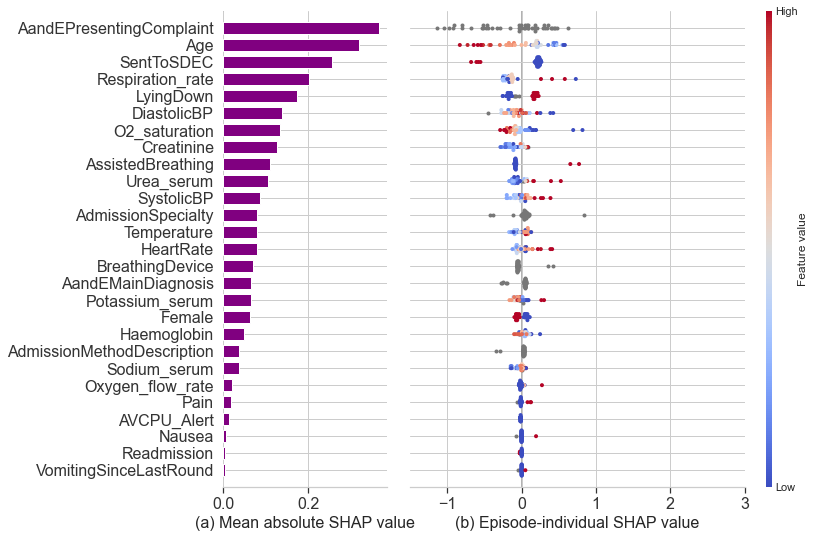

In [161]:
_, explanations = load_model('LightGBM_None_Within-1_with_notes_labs_and_hospital', Notebook.SYS_RESULTS_DIR)
y_pred_proba = Y_PREDS['LightGBM_None_Within-1_with_notes_labs_and_hospital']
plot_shap_features_joint(
    explanations[np.where((y_pred_proba < thresholds[np.abs(recall-0.95).argmin()]) & y_test)], 
    max_display=250,
    figsize=(12, 8),
    wspace=-0.25,
    bar_aspect=0.04,
    topadjust=0.925,
)

In [ ]:

def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    plot_shap_features_joint(
        explanations, 
        max_display=250,
        figsize=(12, 8),
        wspace=-0.25,
        bar_aspect=0.04,
        topadjust=0.925,
        title=title,
        save=save
    )
    
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm.png')

## Time

Vitals: nan -> nan


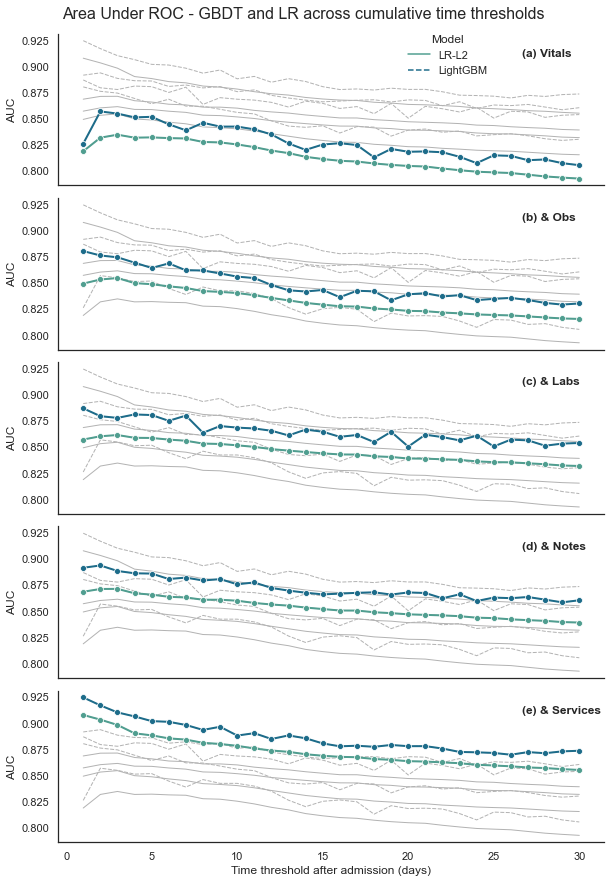

In [19]:
def timeseries_relplot(metrics, save=None):
    df = metrics.copy().rename(columns=dict(estimator='Model'))
    df.features = df.features.replace(dict(
        news='(a) Vitals',
        news_with_phenotype='(b) & Obs',
        with_labs = '(c) & Labs',
        with_notes_and_labs = '(d) & Notes',
        with_notes_labs_and_hospital = '(e) & Services'
    ))
    df.Model = df.Model.replace(pretty_print_models)
    sns.set_theme(style="white")
    g = sns.relplot(
            data=df, x='outcome_within', y='AUC', hue='Model', col='features', marker='o',
        kind='line', palette='crest', linewidth=2, zorder=5, col_wrap=1, height=2.5, aspect=3.5
    )
    g.legend.legendHandles[1].set_linestyle('--')
    sns.move_legend(g, 'upper right', bbox_to_anchor=(0.7, 0.96), frameon=False)
    subp = [(i, features, ax) for i, (features, ax) in enumerate(g.axes_dict.items())]
    for i, features, ax in subp:
        ax.text(.85, .85, features, transform=ax.transAxes, fontweight='bold')
        line = sns.lineplot(
            data=df, x='outcome_within', y='AUC', units='features', style='Model', 
            estimator=None, color='.7', linewidth=1, ax=ax, legend=False
        )
    g.set_titles("")
    g.set_axis_labels("Time threshold after admission (days)", "AUC")
    g.tight_layout()
    g.fig.suptitle('Area Under ROC - GBDT and LR across cumulative time thresholds', x=0.43)
    g.fig.subplots_adjust(top=0.95)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')

    mask = (df.Model == 'LightGBM') & (df.features=='Vitals')
    print(f'Vitals: {df[mask].AUC.max()} -> {df[mask].AUC.min()}')

METRICS_TIME, _ = load_results(Notebook.TIME_RESULTS_DIR)
timeseries_relplot(METRICS_TIME, save=f'{Notebook.IMAGE_DIR}/timeseries_auc.svg')

In [ ]:
model, _ = load_model('LightGBM_None_Within-1_news', Notebook.SYS_RESULTS_DIR)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
y_crit, y_mort, y_icu = (
    sci_test.derive_critical_event(return_series=True), 
    sci_test.derive_death_within(return_series=True), 
    sci_test.derive_critical_care(return_series=True)
)
y_train_crit, y_train_mort, y_train_icu = (
    sci_train.derive_critical_event(return_series=True), 
    sci_train.derive_death_within(return_series=True), 
    sci_train.derive_critical_care(return_series=True)
)

,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
LGBM,,,,,,,
Critical event,0.928391,0.776471,0.022657,0.332553,0.028116,0.779022,0.779 (0.769-0.786)
Mortality only,0.995977,0.247059,0.177966,0.144437,0.188510,0.914547,0.915 (0.868-0.948)
Critical care,0.977888,0.164706,0.016908,0.132036,0.020606,0.837761,0.838 (0.826-0.851)


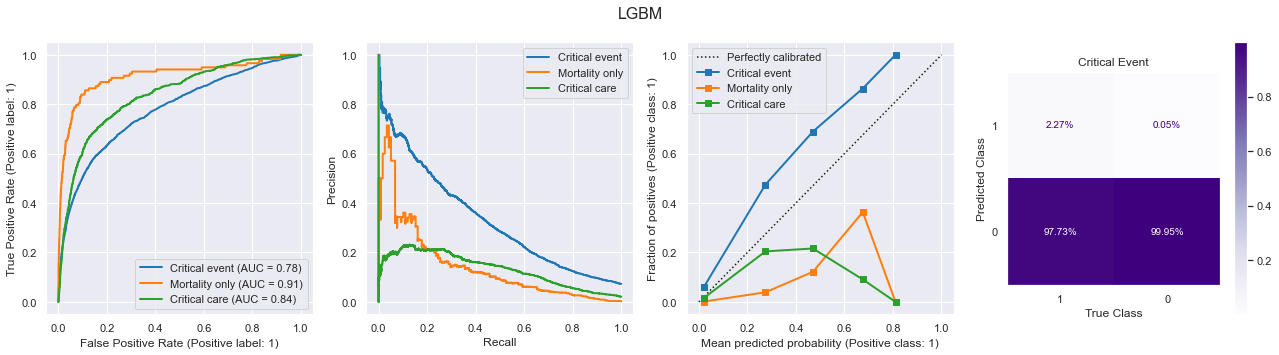

In [ ]:
evaluate_all_outcomes(y_crit, y_mort, y_icu, model.predict(X_test), model.predict_proba(X_test)[:,1], 'LGBM', n_resamples=99)

In [ ]:
X_train, X_test, y_train, y_test = get_xy(scii, Estimator_LightGBM, scii.feature_group_combinations['news'])

### SHAP

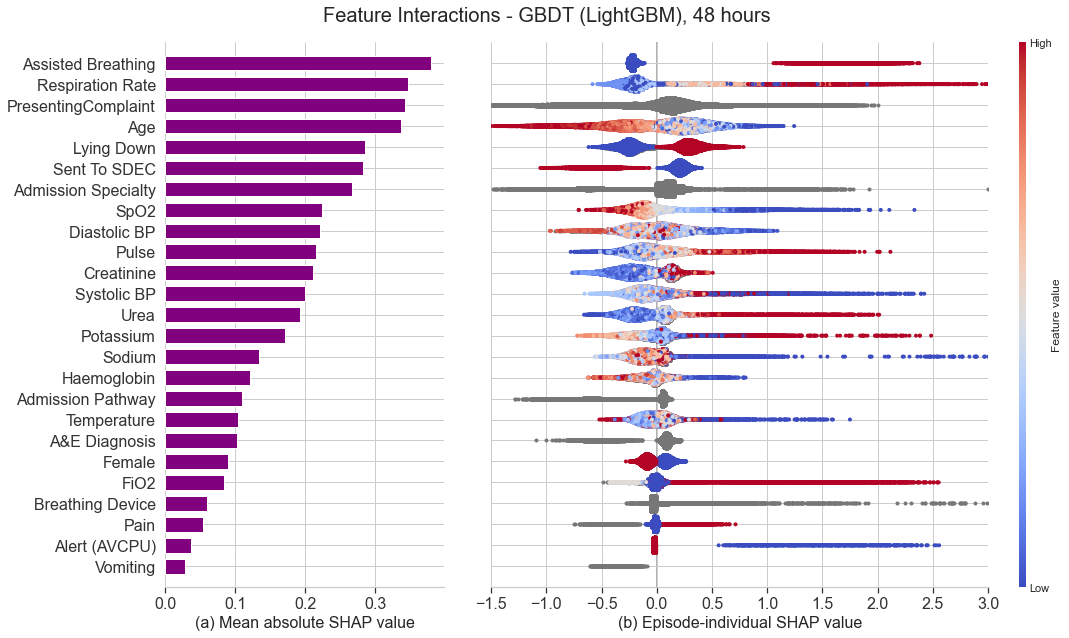

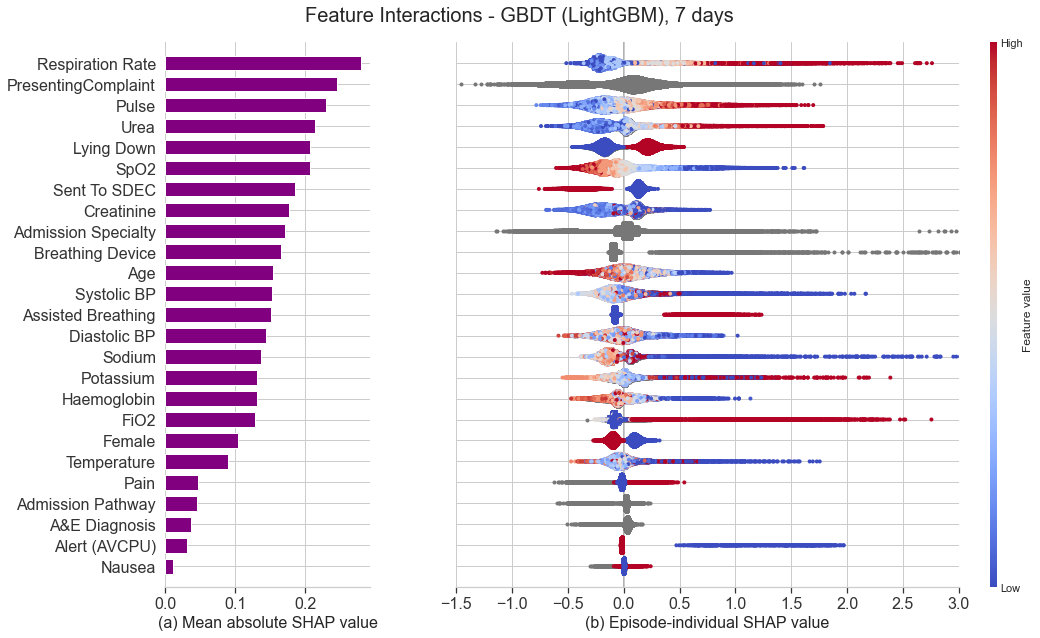

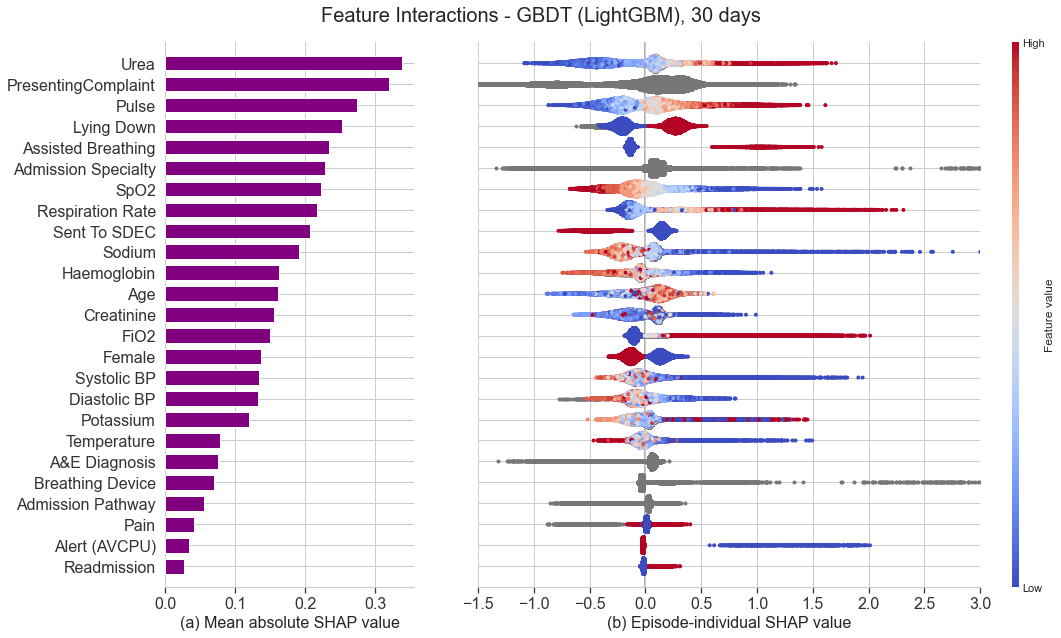

In [ ]:
def lgbm_explanations(name='LightGBM_None_Within-1_with_notes_labs_and_hospital', directory=Notebook.SYS_RESULTS_DIR, save=None, title='Feature Interactions - GBDT (LightGBM)'):
    _, explanations = load_model(name, directory)
    explanations.feature_names = list(map(SCICols.pretty_print_columns.get, explanations.feature_names))
    plot_shap_features_joint(
        explanations, 
        max_display=25,
        figsize=(16, 9),
        wspace=-0.2,
        bar_aspect=0.03,
        topadjust=0.925,
        title=title,
        save=save
    )
    
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_2.png', name='LightGBM_None_Within-2_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 48 hours')
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_7.png', name='LightGBM_None_Within-7_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 7 days')
lgbm_explanations(save=f'{Notebook.IMAGE_DIR}/shap_lgbm_30.png', name='LightGBM_None_Within-30_with_notes_labs_and_hospital', directory=Notebook.TIME_PERSISTED_RESULTS_DIR, title='Feature Interactions - GBDT (LightGBM), 30 days')


## Hyperparameters

{'LogisticRegression': 'LR',
 'L1Regression': 'LR-L1',
 'L2Regression': 'LR-L2',
 'ElasticNetRegression': 'LR-EN',
 'XGBoost': 'XGBoost',
 'LightGBM': 'LightGBM',
 'LinearSVM': 'LinearSVM'}

In [69]:
def hyperparameters():
   # names = [f'{model}_None_Within-1_{feature}' for model in pretty_print_models.keys() for feature in select_feature_groups.keys()]
    params = [
        dict(
            Model=pretty_print_models[model],
            Features=select_feature_groups[features],
            Param=param.split('__')[1],
            Value=str(round(value, 4)) if type(value) == float else value
        ) for model in pretty_print_models.keys() for features in select_feature_groups.keys()
        for param, value in optuna.load_study(
            study_name =f'{model}_None_Within-1_{features}', storage=f'sqlite:///{Notebook.SYS_RESULTS_DIR}/{model}.db'
        ).best_params.items()
    ]
    return pd.DataFrame(params).pivot(index=['Model', 'Param'], columns='Features', values='Value')[select_feature_groups.values()].fillna('None')

params = hyperparameters()
params

Features                        Vitals      & Obs     & Labs    & Notes  \
Model     Param                                                           
LR        class_weight            None       None       None       None   
LR-EN     C                     0.0382     9.2708     9.2871     4.4426   
          class_weight            None       None       None       None   
          l1_ratio              0.4694     0.2623     0.0242     0.9653   
LR-L1     C                     0.0424     7.4049     8.5636     9.4934   
          class_weight            None       None       None       None   
LR-L2     C                     0.0432     9.9964      8.922      6.081   
          class_weight            None       None       None       None   
LightGBM  colsample_bytree       0.972       0.94     0.5294     0.5387   
          is_unbalance           False       True       True       True   
          min_child_samples         47         77         69        135   
          num_leaves                21         45        165        187   
          reg_alpha             1.2452     3.1235     0.0087     0.0015   
          reg_lambda            0.0689     5.0816      5.543     4.8943   
          scale_pos_weight           9       None       None       None   
          subsample             0.8692     0.9526     0.9678     0.9148   
          subsample_freq             7          1          6          2   
LinearSVM alpha                 0.0008     0.0009     0.0007     0.0007   
          class_weight        balanced       None       None       None   
XGBoost   alpha                 0.0017     0.0149        0.0     0.0261   
          colsample_bytree      0.4514     0.2325     0.6908     0.8182   
          eta                   0.0741     0.1576        0.0      0.026   
          gamma                 0.2106        0.0     0.0887     0.0414   
          grow_policy        depthwise  depthwise  lossguide  lossguide   
          lambda                   0.0        0.0     0.2372     0.0029   
          max_depth                  5          5          7          9   
          min_child_weight           2          5          4          2   
          scale_pos_weight           3         12         12          1   
          subsample             0.8882      0.822      0.275     0.4668   
          tree_method           approx     approx     approx     approx   

Features                    & Services  
Model     Param                         
LR        class_weight            None  
LR-EN     C                     0.9524  
          class_weight        balanced  
          l1_ratio              0.9012  
LR-L1     C                      9.806  
          class_weight            None  
LR-L2     C                     3.4434  
          class_weight            None  
LightGBM  colsample_bytree      0.4452  
          is_unbalance           False  
          min_child_samples        126  
          num_leaves                24  
          reg_alpha             0.0003  
          reg_lambda            4.1027  
          scale_pos_weight           1  
          subsample              0.804  
          subsample_freq             3  
LinearSVM alpha                 0.0013  
          class_weight            None  
XGBoost   alpha                  0.005  
          colsample_bytree      0.4395  
          eta                   0.1207  
          gamma                    0.0  
          grow_policy        depthwise  
          lambda                0.0313  
          max_depth                  7  
          min_child_weight           7  
          scale_pos_weight           3  
          subsample             0.9511  
          tree_method             hist

In [70]:
params.index = params.index.set_levels([f'\\verb|{_}|' for _ in params.index.levels[1]], level=1)

In [71]:
print(params.to_latex(multirow=True, bold_rows=False, column_format='llrrrrr', escape=False, formatters=[lambda x: f'\\verb|{x}|' for _ in range(5)]).replace('\\textbackslash verb', '\\verb').replace('& \\textbf{', '& \\verb{'))

\begin{tabular}{llrrrrr}
\toprule
        & Features &            Vitals &             & Obs &            & Labs &           & Notes &        & Services \\
Model & Param &                   &                   &                   &                   &                   \\
\midrule
LR & \verb|class_weight| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| \\
\multirow{3}{*}{LR-EN} & \verb|C| &     \verb|0.0382| &     \verb|9.2708| &     \verb|9.2871| &     \verb|4.4426| &     \verb|0.9524| \\
        & \verb|class_weight| &       \verb|None| &       \verb|None| &       \verb|None| &       \verb|None| &   \verb|balanced| \\
        & \verb|l1_ratio| &     \verb|0.4694| &     \verb|0.2623| &     \verb|0.0242| &     \verb|0.9653| &     \verb|0.9012| \\
\cline{1-7}
\multirow{2}{*}{LR-L1} & \verb|C| &     \verb|0.0424| &     \verb|7.4049| &     \verb|8.5636| &     \verb|9.4934| &      \verb|9.806| \\
        & \verb|class_weight| &       \ver

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Bias

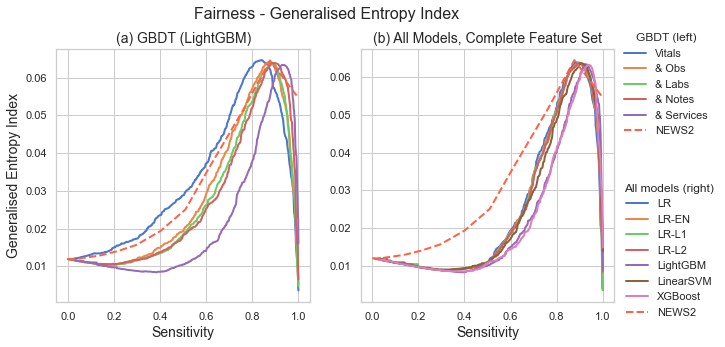

In [115]:
from aif360.sklearn.metrics import generalized_entropy_error, between_group_generalized_entropy_error
def generalized_entropy_curve(y_true, y_pred_proba, prot_attr=None, function=generalized_entropy_error):
    _, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    if function == generalized_entropy_error:
        r = [function(y_true, np.where(y_pred_proba > _, 1, 0)) for _ in thresholds]
    elif function == between_group_generalized_entropy_error:
        r = [
            between_group_generalized_entropy_error(y_true, np.where(y_pred_proba > _, 1, 0), prot_attr=prot_attr)
            for _ in thresholds]
    return recall[:-1], r

def plot_entropy_curves(y_true, y_preds, prot_attr=None, baseline_key=None, ax=None, palette=sns.color_palette("deep"), title='Equalised Odds', function=generalized_entropy_error):
    no_ax = ax is None
    if no_ax:
        sns.set_style("white")
        plt.rc("axes", titlesize=14)
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    for idx, (modelkey, y_pred_proba) in enumerate(y_preds.items()):
        linestyle = "--" if modelkey == baseline_key else "-"
        color = "tomato" if modelkey == baseline_key else palette[idx]
        x, y = generalized_entropy_curve(y_true, y_pred_proba, prot_attr, function=function)
        sns.lineplot(x=x, y=y, label=modelkey, linewidth=2, linestyle=linestyle, color=color, ax=ax)
    
    ax.legend(loc="upper right")
    # sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title)
    ax.set_xlabel("Sensitivity")
    if function == generalized_entropy_error:
        ax.set_ylabel("Generalised Entropy Index")
    elif function == between_group_generalized_entropy_error:
        ax.set_ylabel("Between-Group Unfairness")

def entropy_comparison(metrics, y_preds, prot_attr=None, save=None, function=generalized_entropy_error, title='Fairness - Generalised Entropy Index'):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")
    for _ in ax:
        _.set_box_aspect(1)
    
    y_test = sci_test.derive_critical_event(within=1, return_series=True).loc[y_preds.index]
    baseline_news = {'NEWS2': sci_test.loc[y_test.index, 'NEWS_score']}
    y_preds_l, y_preds_r = model_preds_across_features(metrics, y_preds, 'LightGBM'), all_model_preds(metrics, y_preds)

    plot_entropy_curves(y_test, y_preds_l | baseline_news, ax=ax[0], title='(a) GBDT (LightGBM)', baseline_key='NEWS2', palette=sns.color_palette('muted'), function=function, prot_attr=prot_attr)
    plot_entropy_curves(y_test, y_preds_r | baseline_news, ax=ax[1], title='(b) All Models, Complete Feature Set', baseline_key='NEWS2', palette=sns.color_palette('muted'), function=function, prot_attr=prot_attr)

    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(2.2, 1.1), frameon=False, title='GBDT (left)')
    sns.move_legend(ax[1], "lower left", bbox_to_anchor=(1, -0.1), frameon=False, title='All models (right)')
    ax[1].set_ylabel(None)
   # fig.tight_layout(h_pad=0.5, w_pad=0.5)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', format='svg')
entropy_comparison(METRICS, Y_PREDS, save=f'{Notebook.IMAGE_DIR}/entropy.svg')        

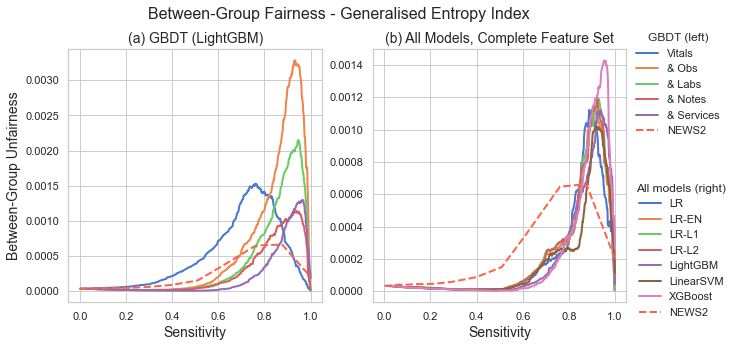

In [116]:
entropy_comparison(METRICS, Y_PREDS, function=between_group_generalized_entropy_error, prot_attr=sci_test.derive_critical_event(return_series=True).set_axis(sci_test[['Female', 'AgeBand']]).index, save=f'{Notebook.IMAGE_DIR}/entropy_between.svg', title='Between-Group Fairness - Generalised Entropy Index')

In [51]:
from aif360.sklearn.metrics.metrics import intersection, smoothed_base_rate
from itertools import permutations

def soft_base_rate(y_true, y_pred=None, *, concentration=1.0, pos_label=1, sample_weight=None):
    return (np.sum(y_true) + concentration)/(y_true.shape[0] + concentration)

def soft_selection_rate(y_true, y_pred, *, concentration=1.0, pos_label=1, sample_weight=None):
    return soft_base_rate(y_pred, concentration=concentration, pos_label=pos_label, sample_weight=sample_weight)

def soft_edf(y_true, y_pred=None, *, prot_attr=None, pos_label=1, concentration=1.0, sample_weight=None):
    rate = soft_base_rate if y_pred is None else soft_selection_rate
    sbr = intersection(rate, y_true, y_pred, prot_attr=prot_attr)
    logsbr = np.log(sbr)
    pos_ratio = max(abs(i - j) for i, j in permutations(logsbr, 2))
    lognegsbr = np.log(1 - np.array(sbr))
    neg_ratio = max(abs(i - j) for i, j in permutations(lognegsbr, 2))
    return max(pos_ratio, neg_ratio)

def soft_df_bias_amplification(y_true, y_pred, prot_attr, pos_label=1, concentration=1.0, sample_weight=None):
    eps_true = soft_edf(y_true, prot_attr=prot_attr, pos_label=pos_label,
                            concentration=concentration,
                            sample_weight=sample_weight)
    eps_pred = soft_edf(y_true, y_pred, prot_attr=prot_attr,
                            pos_label=pos_label, concentration=concentration,
                            sample_weight=sample_weight)
    return eps_pred - eps_true

def bootstrap_bias_amplification(y_true, y_score, prot_attr, n_resamples=99):
    center = soft_df_bias_amplification(y_true, y_score, prot_attr)
    res = st.bootstrap(
        data=(y_true.to_numpy(), y_score.to_numpy(), prot_attr.to_numpy()),
        statistic=soft_df_bias_amplification,
        confidence_level=0.95,
        method="percentile",
        n_resamples=n_resamples,
        vectorized=False,
        paired=True,
        random_state=42,
    )
    return res.confidence_interval.low, center, res.confidence_interval.high

In [52]:
def calc_bias_amplifications():
    df = sci_test[sci_test.AgeBand != '16 and Under'].copy()
    y_test = df.CriticalEvent
    prot_attrs = dict(
        Age=df.AgeBand,
        Sex=df.Female,
        Both=y_test.set_axis(df[['AgeBand', 'Female']]).index,
    )

    metrics = METRICS[(METRICS.resampler=='None')&(METRICS.features.isin(select_feature_groups.keys()))].copy()
    get_dict = lambda low, mid, high: dict(
            Bias_Amp = mid,
            Bias_Amp_Lower = low,
            Bias_Amp_Upper = high
        )
  
    df = pd.DataFrame((
        dict(
            name=_['name'],
            estimator=pretty_print_models[_['estimator']],
            features=select_feature_groups[_['features']],
            protected=attr_key
        )| get_dict(*bootstrap_bias_amplification(
            y_test, 
            Y_PREDS.loc[df.index, _['name']],
            prot_attr, 
            n_resamples=9
        )) for _ in metrics.to_dict(orient='records') for attr_key, prot_attr in prot_attrs.items()
    ))

    return df
    df['Bias'] = df.Bias_Amp.map('{:.3f}'.format) + ' (' + df.Bias_Amp_Lower.map('{:.3f}'.format) + ' - ' + df.Bias_Amp_Upper.map('{:.3f}'.format) + ')'
    return df.pivot(index=['features', 'estimator'], columns=['protected'], values='Bias')[['Sex', 'Age', 'Both']].loc[select_feature_groups.values()]


df = calc_bias_amplifications()
df

,name,estimator,features,protected,Bias_Amp,Bias_Amp_Lower,Bias_Amp_Upper
0,ElasticNetRegression_None_Within-1_news,LR-EN,Vitals,Age,0.242427,0.003820,0.421549
1,ElasticNetRegression_None_Within-1_news,LR-EN,Vitals,Sex,-0.204971,-0.236211,-0.083560
2,ElasticNetRegression_None_Within-1_news,LR-EN,Vitals,Both,-0.060132,-0.167463,0.156088
3,ElasticNetRegression_None_Within-1_news_with_p...,LR-EN,& Obs,Age,-0.426429,-0.633843,-0.251700
4,ElasticNetRegression_None_Within-1_news_with_p...,LR-EN,& Obs,Sex,0.050638,0.013740,0.127276
5,ElasticNetRegression_None_Within-1_news_with_p...,LR-EN,& Obs,Both,-0.577308,-0.747434,-0.342422
6,ElasticNetRegression_None_Within-1_with_labs,LR-EN,& Labs,Age,-0.446487,-0.650932,-0.264901
7,ElasticNetRegression_None_Within-1_with_labs,LR-EN,& Labs,Sex,0.074360,0.039079,0.161531
8,ElasticNetRegression_None_Within-1_with_labs,LR-EN,& Labs,Both,-0.565690,-0.743631,-0.342559
9,ElasticNetRegression_None_Within-1_with_notes_...,LR-EN,& Notes,Age,-0.423824,-0.616704,-0.245764


In [55]:
df[df.protected=='Both'].Bias_Amp.median()

-0.5422473415546976

In [53]:
print(df.loc[select_feature_groups.values()].to_latex(bold_rows=True, multicolumn=True, multirow=True, column_format='llrrr'))

KeyError: "None of [Index(['Vitals', '& Obs', '& Labs', '& Notes', '& Services'], dtype='object')] are in the [index]"